In [ ]:
pip install --upgrade pip

In [ ]:
%pip install -q safetensors

In [12]:
import pandas as pd
import os
import torch.nn.functional as F
from PIL import Image
import torch
from transformers import CLIPProcessor, CLIPModel
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [10]:
model_id = "openai/clip-vit-base-patch32"

model = CLIPModel.from_pretrained(model_id)
processor = CLIPProcessor.from_pretrained(model_id)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if device.type == "cuda":
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

model.to(device)

Using device: cpu


CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

## Analysis: Authors with Paintings from Different Time Frames

Let's check if the same author has paintings made in different time frames in the semart_train.csv dataset.

In [3]:
# Load the semart_train.csv file
df_train = pd.read_csv("semart_train.csv", encoding='latin-1', on_bad_lines='skip', engine='python', sep='\t')

# Display basic info about the dataset
print(f"Total number of paintings: {len(df_train)}")
print(f"\nColumn names: {df_train.columns.tolist()}")
print(f"\nFirst few rows:")
df_train.head()

Total number of paintings: 19244

Column names: ['IMAGE_FILE', 'DESCRIPTION', 'AUTHOR', 'TITLE', 'TECHNIQUE', 'DATE', 'TYPE', 'SCHOOL', 'TIMEFRAME']

First few rows:


,IMAGE_FILE,DESCRIPTION,AUTHOR,TITLE,TECHNIQUE,DATE,TYPE,SCHOOL,TIMEFRAME
0,19873-1darmst.jpg,"The Meyer or Darmstadt Madonna is the last, mo...","HOLBEIN, Hans the Younger",Darmstadt Madonna,"Oil on limewood, 147 x 102 cm",1526 and after 1528,religious,German,1501-1550
1,18759-guard301.jpg,Whereas Canaletto incorporates classically ins...,"GUARDI, Francesco",Landscape with a Fisherman's Tent,"Oil on canvas, 49 x 77 cm",1770-75,landscape,Italian,1751-1800
2,04589-temptati.jpg,In this painting the refinement of the colouri...,"BILIVERT, Giovanni",The Temptation of Charles and Ubalde,"Oil on copper, 37 x 28 cm",1629-30,religious,Italian,1601-1650
3,15104-magi.jpg,"The left side of the painting was cut, origina...",GEERTGEN tot Sint Jans,Adoration of the Magi,"Panel, 111 x 69 cm",1480-85,religious,Netherlandish,1451-1500
4,36582-paolo_f1.jpg,The painting illustrates a famous episode from...,"SCHEFFER, Ary",The Ghosts of Paolo and Francesca Appear to Da...,"Oil on canvas, 167 x 234 cm",1835,other,Dutch,1801-1850


## Author Prediction Using CLIP

Using the same CLIP similarity logic, let's predict the author of 10 random paintings by comparing each image against all authors in the dataset.

In [4]:
# Get all unique authors from the dataset
all_authors = df_train['AUTHOR'].unique().tolist()
print(f"Total number of unique authors in dataset: {len(all_authors)}")

# Select 10 random paintings from the dataset
import random
random.seed(42)  # For reproducibility
sample_paintings = df_train.sample(n=10, random_state=42)

print(f"\nSelected {len(sample_paintings)} random paintings for prediction:")
sample_paintings[['IMAGE_FILE', 'AUTHOR', 'TITLE', 'DATE']].head(10)

Total number of unique authors in dataset: 3166

Selected 10 random paintings for prediction:


,IMAGE_FILE,AUTHOR,TITLE,DATE
4318,39373-27appari.jpg,TINTORETTO,The Apparition of St Roch,c. 1588
2117,29159-turbulen.jpg,"MULIER, Pieter the Elder",Turbulent Sea,-
4999,07268-canal718.jpg,CANALETTO,Old Walton Bridge,1754
9651,37876-pieta.jpg,"STANZIONE, Massimo",Piet?,1621-25
1162,11101-cottage.jpg,"DECKER, Cornelis Gerritsz",Cottage among Trees on Bank of Stream,1669
14279,38572-hustleca.jpg,"TENIERS, David the Younger",The Hustle-Cap,-
13303,10272-04donor1.jpg,"CRANACH, Lucas the Elder",Portrait of a Donor,c. 1508
7306,32306-04selfpo.jpg,"POUSSIN, Nicolas",Self-Portrait,1650
4371,33592-134portr.jpg,REMBRANDT Harmenszoon van Rijn,Portrait of an Old Man,1665
13133,38317-portrait.jpg,"SUBLEYRAS, Pierre",Portrait of a Man,c. 1745


In [5]:
# Function to predict author for a given image
def predict_author_for_image(image_path, authors_list, model, processor, device):
    """
    Predict the author of a painting using CLIP similarity
    """
    try:
        # Load and preprocess the image
        image = Image.open(image_path)
        
        # Preprocess inputs
        inputs = processor(text=authors_list, images=image, return_tensors="pt", padding=True)
        
        # Move all input tensors to the same device as the model
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        # Run the model
        outputs = model(**inputs)
        image_embeddings = outputs.image_embeds
        text_embeddings = outputs.text_embeds
        
        # Compute similarity
        similarity_scores = F.cosine_similarity(image_embeddings, text_embeddings)
        
        # Get best match
        best_idx = similarity_scores.argmax().item()
        best_author = authors_list[best_idx]
        best_score = similarity_scores[best_idx].item()
        
        # Get top 5 matches
        top5_indices = similarity_scores.argsort(descending=True)[:5]
        top5_matches = [(authors_list[idx], similarity_scores[idx].item()) for idx in top5_indices]
        
        return best_author, best_score, top5_matches
    
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None, None, None

print("Function defined successfully!")

Function defined successfully!


## Author Prediction for Top 100 Most Prolific Artists

Let's improve prediction accuracy by focusing on the 100 authors with the most paintings in the dataset (excluding Unknown artists).

In [6]:
# Find the top 100 authors with the most paintings (excluding Unknown artists)
author_counts = df_train['AUTHOR'].value_counts()

# Filter out authors with "Unknown" in their name
author_counts_filtered = author_counts[~author_counts.index.str.contains('Unknown', case=False, na=False)]
top_100_authors = author_counts_filtered.head(100).index.tolist()

print(f"Top 100 authors with most paintings (excluding Unknown artists):")
print("="*80)
for i, author in enumerate(top_100_authors, 1):
    count = author_counts[author]
    print(f"{i:3d}. {author:40s} - {count:3d} paintings")

Top 100 authors with most paintings (excluding Unknown artists):
  1. GOGH, Vincent van                        - 291 paintings
  2. REMBRANDT Harmenszoon van Rijn           - 236 paintings
  3. GIOTTO di Bondone                        - 224 paintings
  4. RUBENS, Peter Paul                       - 187 paintings
  5. TIZIANO Vecellio                         - 181 paintings
  6. GRECO, El                                - 177 paintings
  7. VERONESE, Paolo                          - 170 paintings
  8. RAFFAELLO Sanzio                         - 169 paintings
  9. TINTORETTO                               - 168 paintings
 10. CRANACH, Lucas the Elder                 - 166 paintings
 11. TIEPOLO, Giovanni Battista               - 165 paintings
 12. ANGELICO, Fra                            - 150 paintings
 13. MEMLING, Hans                            - 125 paintings
 14. MICHELANGELO Buonarroti                  - 120 paintings
 15. MANTEGNA, Andrea                         - 111 paintings
 16. 

In [7]:
# Use ALL paintings from the top 100 authors
paintings_top100 = df_train[df_train['AUTHOR'].isin(top_100_authors)]

print(f"Total paintings by top 100 authors: {len(paintings_top100)}")
print(f"\nWill predict authors for all {len(paintings_top100)} paintings")
print(f"\nFirst 10 paintings:")
paintings_top100[['IMAGE_FILE', 'AUTHOR', 'TITLE', 'DATE']].head(10)

Total paintings by top 100 authors: 7131

Will predict authors for all 7131 paintings

First 10 paintings:


,IMAGE_FILE,AUTHOR,TITLE,DATE
0,19873-1darmst.jpg,"HOLBEIN, Hans the Younger",Darmstadt Madonna,1526 and after 1528
1,18759-guard301.jpg,"GUARDI, Francesco",Landscape with a Fisherman's Tent,1770-75
5,00930-30coron.jpg,"ANGELICO, Fra",The Coronation of the Virgin,1434-35
7,18424-2105grec.jpg,"GRECO, El",Portrait of Cardinal Tavera,1608-14
8,21949-4lastsu3.jpg,LEONARDO da Vinci,The Last Supper,1498
13,39738-04organ.jpg,TIZIANO Vecellio,Venus and Cupid with an Organist,1548-49
17,12035-painstud.jpg,"DOU, Gerrit",Painter in his Studio,1647
20,20109-44hooch.jpg,"HOOCH, Pieter de",Woman Reading a Letter,1664
21,09651-03barber.jpg,"CORTONA, Pietro da",Ceiling vault (centre part),1633-39
22,12270-verso14.jpg,DUCCIO di Buoninsegna,Christ Before King Herod (scene 14),1308-11


In [11]:
# Predict authors for ALL paintings by top 100 authors (using only top 100 authors as candidates)
top100_results = []

print(f"Predicting authors for all {len(paintings_top100)} paintings (Top 100 authors only)...\n")
print("="*100)

total_paintings = len(paintings_top100)
for counter, (idx, row) in enumerate(paintings_top100.iterrows(), 1):
    
    image_file = row['IMAGE_FILE']
    true_author = row['AUTHOR']
    title = row['TITLE']
    image_path = os.path.join("Images", image_file)
    
    
    # Show progress every 100 paintings or for first 10
    if counter <= 10 or counter % 100 == 0:
        print(f"\n[{counter}/{total_paintings}] Processing: {title} by {true_author}")
    
    # Predict author using only top 100 authors
    predicted_author, confidence, top5_matches = predict_author_for_image(
        image_path, top_100_authors, model, processor, device
    )
    
    if predicted_author:
        is_correct = predicted_author == true_author
        symbol = "✅" if is_correct else "❌"
        
        print(f"   {symbol} Predicted Author: {predicted_author} (confidence: {confidence:.4f})")
        # Only show detailed predictions for first 10 or every 100th painting
        if counter <= 10 or counter % 100 == 0:
            print(f"   {symbol} Predicted: {predicted_author} (confidence: {confidence:.4f})")
            if not is_correct:
                print(f"      Top 5: {', '.join([f'{a} ({s:.3f})' for a, s in top5_matches[:5]])}")
        top100_results.append({
            'image_file': image_file,
            'title': title,
            'true_author': true_author,
            'predicted_author': predicted_author,
            'confidence': confidence,
            'correct': is_correct
        })
    

print(f"\n\nPrediction complete!")

Predicting authors for all 7131 paintings (Top 100 authors only)...


[1/7131] Processing: Darmstadt Madonna by HOLBEIN, Hans the Younger
   ❌ Predicted Author: LIPPI, Filippino (confidence: 0.2912)
   ❌ Predicted: LIPPI, Filippino (confidence: 0.2912)
      Top 5: LIPPI, Filippino (0.291), LIPPI, Fra Filippo (0.291), ANGELICO, Fra (0.283), PINTURICCHIO (0.281), CRANACH, Lucas the Elder (0.277)

[2/7131] Processing: Landscape with a Fisherman's Tent by GUARDI, Francesco
   ❌ Predicted Author: RUISDAEL, Jacob Isaackszon van (confidence: 0.3486)
   ❌ Predicted: RUISDAEL, Jacob Isaackszon van (confidence: 0.3486)
      Top 5: RUISDAEL, Jacob Isaackszon van (0.349), GUARDI, Francesco (0.318), CANALETTO (0.317), BELLOTTO, Bernardo (0.315), GOYEN, Jan van (0.305)

[3/7131] Processing: The Coronation of the Virgin by ANGELICO, Fra
   ❌ Predicted Author: SIMONE MARTINI (confidence: 0.2850)
   ❌ Predicted: SIMONE MARTINI (confidence: 0.2850)
      Top 5: SIMONE MARTINI (0.285), GIOTTO di Bondon

   ✅ Predicted Author: RENOIR, Pierre-Auguste (confidence: 0.3269)
   ❌ Predicted Author: GOZZOLI, Benozzo (confidence: 0.3250)
   ❌ Predicted Author: POUSSIN, Nicolas (confidence: 0.3334)
   ❌ Predicted Author: MEMLING, Hans (confidence: 0.3208)
   ❌ Predicted Author: MICHELANGELO Buonarroti (confidence: 0.3023)
   ❌ Predicted Author: MANTEGNA, Andrea (confidence: 0.3137)
   ❌ Predicted Author: SIMONE MARTINI (confidence: 0.3183)
   ✅ Predicted Author: BRUEGHEL, Jan the Elder (confidence: 0.3218)
   ❌ Predicted Author: MANTEGNA, Andrea (confidence: 0.3135)
   ❌ Predicted Author: PERUGINO, Pietro (confidence: 0.2953)

[100/7131] Processing: Martyrdom of St Erasmus (triptych) by BOUTS, Dieric the Elder
   ❌ Predicted Author: BOSCH, Hieronymus (confidence: 0.2881)
   ❌ Predicted: BOSCH, Hieronymus (confidence: 0.2881)
      Top 5: BOSCH, Hieronymus (0.288), PINTURICCHIO (0.286), CRANACH, Lucas the Elder (0.280), CARPACCIO, Vittore (0.269), UCCELLO, Paolo (0.268)
   ✅ Predicted Author: PE

   ❌ Predicted Author: ZURBARÁN, Francisco de (confidence: 0.3304)
   ❌ Predicted Author: MASOLINO da Panicale (confidence: 0.2873)
   ❌ Predicted Author: CORTONA, Pietro da (confidence: 0.2969)
   ❌ Predicted Author: PINTURICCHIO (confidence: 0.2916)
   ❌ Predicted Author: PINTURICCHIO (confidence: 0.3286)
   ✅ Predicted Author: MONET, Claude (confidence: 0.3095)
   ✅ Predicted Author: RUBENS, Peter Paul (confidence: 0.2954)
   ❌ Predicted Author: FRAGONARD, Jean-Honoré (confidence: 0.2981)
   ❌ Predicted Author: TINTORETTO (confidence: 0.3310)
   ❌ Predicted Author: GOYA Y LUCIENTES, Francisco de (confidence: 0.3053)
   ❌ Predicted Author: FRAGONARD, Jean-Honoré (confidence: 0.3136)
   ❌ Predicted Author: RUBENS, Peter Paul (confidence: 0.2884)
   ❌ Predicted Author: BRONZINO, Agnolo (confidence: 0.3090)
   ✅ Predicted Author: TOULOUSE-LAUTREC, Henri de (confidence: 0.3108)
   ✅ Predicted Author: GIOTTO di Bondone (confidence: 0.3061)
   ❌ Predicted Author: MURILLO, Bartolomé Esteban

   ✅ Predicted Author: REMBRANDT Harmenszoon van Rijn (confidence: 0.2909)
   ❌ Predicted Author: LOTTO, Lorenzo (confidence: 0.3110)
   ✅ Predicted Author: TOULOUSE-LAUTREC, Henri de (confidence: 0.3327)
   ❌ Predicted Author: GOZZOLI, Benozzo (confidence: 0.3168)
   ✅ Predicted Author: TOULOUSE-LAUTREC, Henri de (confidence: 0.2932)
   ✅ Predicted Author: CANALETTO (confidence: 0.3050)
   ✅ Predicted Author: GOGH, Vincent van (confidence: 0.2788)
   ❌ Predicted Author: PIERO DELLA FRANCESCA (confidence: 0.3104)
   ❌ Predicted Author: BRONZINO, Agnolo (confidence: 0.2901)
   ❌ Predicted Author: DUCCIO di Buoninsegna (confidence: 0.3194)
   ✅ Predicted Author: MONET, Claude (confidence: 0.2983)
   ❌ Predicted Author: RENOIR, Pierre-Auguste (confidence: 0.2957)
   ✅ Predicted Author: TOULOUSE-LAUTREC, Henri de (confidence: 0.3067)
   ❌ Predicted Author: DUCCIO di Buoninsegna (confidence: 0.3143)
   ❌ Predicted Author: PERUGINO, Pietro (confidence: 0.3171)
   ❌ Predicted Author: GOYA Y L

   ❌ Predicted Author: LORENZO Monaco (confidence: 0.2832)
   ✅ Predicted Author: GOGH, Vincent van (confidence: 0.2687)
   ❌ Predicted Author: VERONESE, Paolo (confidence: 0.2986)
   ❌ Predicted Author: GUARDI, Francesco (confidence: 0.2986)
   ❌ Predicted Author: PERUGINO, Pietro (confidence: 0.3253)
   ❌ Predicted Author: MASOLINO da Panicale (confidence: 0.2951)
   ✅ Predicted Author: TINTORETTO (confidence: 0.3347)
   ❌ Predicted Author: RUISDAEL, Jacob Isaackszon van (confidence: 0.3208)
   ❌ Predicted Author: PINTURICCHIO (confidence: 0.3193)
   ✅ Predicted Author: CANALETTO (confidence: 0.3465)
   ❌ Predicted Author: RENOIR, Pierre-Auguste (confidence: 0.2908)
   ❌ Predicted Author: RUISDAEL, Jacob Isaackszon van (confidence: 0.3099)
   ❌ Predicted Author: PINTURICCHIO (confidence: 0.3114)
   ❌ Predicted Author: CARAVAGGIO (confidence: 0.3189)
   ❌ Predicted Author: MICHELANGELO Buonarroti (confidence: 0.3205)
   ❌ Predicted Author: SIMONE MARTINI (confidence: 0.3221)
   ✅ Pred

   ❌ Predicted Author: PONTORMO, Jacopo (confidence: 0.3151)
   ✅ Predicted Author: CANALETTO (confidence: 0.3204)
   ❌ Predicted Author: BRONZINO, Agnolo (confidence: 0.3526)
   ✅ Predicted Author: BELLOTTO, Bernardo (confidence: 0.3358)
   ❌ Predicted Author: VERMEER, Johannes (confidence: 0.3043)

[600/7131] Processing: Madonna of the Star by ANGELICO, Fra
   ❌ Predicted Author: SIMONE MARTINI (confidence: 0.2989)
   ❌ Predicted: SIMONE MARTINI (confidence: 0.2989)
      Top 5: SIMONE MARTINI (0.299), MASOLINO da Panicale (0.291), PINTURICCHIO (0.288), GIOTTO di Bondone (0.282), LORENZETTI, Pietro (0.279)
   ❌ Predicted Author: MASOLINO da Panicale (confidence: 0.3148)
   ✅ Predicted Author: CRANACH, Lucas the Elder (confidence: 0.3373)
   ❌ Predicted Author: TERBORCH, Gerard (confidence: 0.3174)
   ❌ Predicted Author: LONGHI, Pietro (confidence: 0.2981)
   ✅ Predicted Author: RUBENS, Peter Paul (confidence: 0.3009)
   ✅ Predicted Author: CRANACH, Lucas the Elder (confidence: 0.3298

   ❌ Predicted Author: RUISDAEL, Jacob Isaackszon van (confidence: 0.3246)
   ✅ Predicted Author: CÉZANNE, Paul (confidence: 0.3248)
   ✅ Predicted Author: PERUGINO, Pietro (confidence: 0.3380)
   ❌ Predicted Author: VERONESE, Paolo (confidence: 0.3068)
   ❌ Predicted Author: LIPPI, Filippino (confidence: 0.2737)
   ❌ Predicted Author: LIPPI, Fra Filippo (confidence: 0.2976)
   ❌ Predicted Author: GUARDI, Francesco (confidence: 0.3086)
   ❌ Predicted Author: TINTORETTO (confidence: 0.3168)
   ❌ Predicted Author: LORENZETTI, Pietro (confidence: 0.3097)
   ❌ Predicted Author: CLAUDE LORRAIN (confidence: 0.3168)
   ❌ Predicted Author: CORTONA, Pietro da (confidence: 0.3022)
   ❌ Predicted Author: UCCELLO, Paolo (confidence: 0.3144)
   ❌ Predicted Author: LORENZETTI, Pietro (confidence: 0.3035)
   ✅ Predicted Author: MONET, Claude (confidence: 0.2957)
   ❌ Predicted Author: UCCELLO, Paolo (confidence: 0.3535)
   ❌ Predicted Author: PINTURICCHIO (confidence: 0.3288)
   ❌ Predicted Author: H

   ❌ Predicted Author: PERUGINO, Pietro (confidence: 0.3207)
   ❌ Predicted Author: LORENZETTI, Pietro (confidence: 0.3139)
   ✅ Predicted Author: PERUGINO, Pietro (confidence: 0.3305)
   ❌ Predicted Author: CANALETTO (confidence: 0.3287)
   ✅ Predicted Author: GOGH, Vincent van (confidence: 0.3015)
   ❌ Predicted Author: TIEPOLO, Giovanni Domenico (confidence: 0.3309)
   ❌ Predicted Author: ZURBARÁN, Francisco de (confidence: 0.3151)
   ❌ Predicted Author: BOSCH, Hieronymus (confidence: 0.3012)
   ❌ Predicted Author: TINTORETTO (confidence: 0.3302)
   ❌ Predicted Author: MASOLINO da Panicale (confidence: 0.2777)
   ❌ Predicted Author: PINTURICCHIO (confidence: 0.2853)
   ✅ Predicted Author: GIOTTO di Bondone (confidence: 0.3027)
   ✅ Predicted Author: VERONESE, Paolo (confidence: 0.3222)
   ✅ Predicted Author: LOTTO, Lorenzo (confidence: 0.2997)
   ❌ Predicted Author: TIEPOLO, Giovanni Domenico (confidence: 0.3230)
   ❌ Predicted Author: PERUGINO, Pietro (confidence: 0.3049)
   ❌ Pred

   ❌ Predicted Author: MEMLING, Hans (confidence: 0.2941)
   ❌ Predicted Author: CANALETTO (confidence: 0.3491)
   ❌ Predicted Author: SIMONE MARTINI (confidence: 0.2742)
   ❌ Predicted Author: BRONZINO, Agnolo (confidence: 0.3264)
   ❌ Predicted Author: MEMLING, Hans (confidence: 0.3310)
   ✅ Predicted Author: GOGH, Vincent van (confidence: 0.2957)
   ❌ Predicted Author: DAVID, Jacques-Louis (confidence: 0.2794)
   ❌ Predicted Author: TIEPOLO, Giovanni Domenico (confidence: 0.3418)
   ❌ Predicted Author: VERMEER, Johannes (confidence: 0.2836)
   ❌ Predicted Author: UCCELLO, Paolo (confidence: 0.3069)
   ❌ Predicted Author: GUARDI, Francesco (confidence: 0.2853)
   ❌ Predicted Author: RUISDAEL, Jacob Isaackszon van (confidence: 0.3352)
   ❌ Predicted Author: BELLOTTO, Bernardo (confidence: 0.3051)
   ✅ Predicted Author: GUARDI, Francesco (confidence: 0.3274)
   ❌ Predicted Author: GOYA Y LUCIENTES, Francisco de (confidence: 0.3332)
   ✅ Predicted Author: FRAGONARD, Jean-Honoré (confide

   ❌ Predicted Author: LORENZETTI, Pietro (confidence: 0.3270)
   ✅ Predicted Author: WEYDEN, Rogier van der (confidence: 0.3036)
   ❌ Predicted Author: MURILLO, Bartolomé Esteban (confidence: 0.3224)
   ❌ Predicted Author: LIPPI, Filippino (confidence: 0.2794)

[1100/7131] Processing: Creation of the Sun, Moon, and Plants by MICHELANGELO Buonarroti
   ✅ Predicted Author: MICHELANGELO Buonarroti (confidence: 0.3083)
   ✅ Predicted: MICHELANGELO Buonarroti (confidence: 0.3083)
   ❌ Predicted Author: SIMONE MARTINI (confidence: 0.3125)
   ❌ Predicted Author: BRONZINO, Agnolo (confidence: 0.2897)
   ❌ Predicted Author: COURBET, Gustave (confidence: 0.3237)
   ✅ Predicted Author: GIOTTO di Bondone (confidence: 0.2994)
   ❌ Predicted Author: BRUEGEL, Pieter the Elder (confidence: 0.3300)
   ❌ Predicted Author: LIPPI, Filippino (confidence: 0.3344)
   ❌ Predicted Author: GOZZOLI, Benozzo (confidence: 0.3039)
   ❌ Predicted Author: GIOTTO di Bondone (confidence: 0.3020)
   ❌ Predicted Author:

   ❌ Predicted Author: TOULOUSE-LAUTREC, Henri de (confidence: 0.2807)
   ❌ Predicted Author: MEMLING, Hans (confidence: 0.2954)
   ✅ Predicted Author: CLAUDE LORRAIN (confidence: 0.3011)
   ❌ Predicted Author: LORENZETTI, Pietro (confidence: 0.3088)
   ❌ Predicted Author: HOOCH, Pieter de (confidence: 0.2597)
   ❌ Predicted Author: GIOTTO di Bondone (confidence: 0.2892)
   ❌ Predicted Author: ANDREA DEL SARTO (confidence: 0.3228)
   ❌ Predicted Author: TIEPOLO, Giovanni Battista (confidence: 0.2802)
   ✅ Predicted Author: CANALETTO (confidence: 0.3304)
   ✅ Predicted Author: POUSSIN, Nicolas (confidence: 0.3076)
   ❌ Predicted Author: CORTONA, Pietro da (confidence: 0.3157)
   ✅ Predicted Author: VERONESE, Paolo (confidence: 0.3222)
   ❌ Predicted Author: TIEPOLO, Giovanni Domenico (confidence: 0.3114)
   ❌ Predicted Author: VERNET, Claude-Joseph (confidence: 0.3038)
   ✅ Predicted Author: GOYA Y LUCIENTES, Francisco de (confidence: 0.3321)
   ✅ Predicted Author: POUSSIN, Nicolas (con

   ✅ Predicted Author: TINTORETTO (confidence: 0.3208)
   ❌ Predicted Author: PINTURICCHIO (confidence: 0.2971)
   ✅ Predicted Author: TOULOUSE-LAUTREC, Henri de (confidence: 0.3052)
   ✅ Predicted Author: CARAVAGGIO (confidence: 0.3315)
   ❌ Predicted Author: TINTORETTO (confidence: 0.2975)
   ✅ Predicted Author: VERMEER, Johannes (confidence: 0.3347)
   ✅ Predicted Author: UCCELLO, Paolo (confidence: 0.3210)
   ❌ Predicted Author: PINTURICCHIO (confidence: 0.3143)
   ❌ Predicted Author: PERUGINO, Pietro (confidence: 0.3137)
   ❌ Predicted Author: VERONESE, Paolo (confidence: 0.3127)
   ❌ Predicted Author: PINTURICCHIO (confidence: 0.3199)
   ❌ Predicted Author: STEEN, Jan (confidence: 0.2608)
   ❌ Predicted Author: BRUEGHEL, Jan the Elder (confidence: 0.3106)
   ❌ Predicted Author: TIEPOLO, Giovanni Battista (confidence: 0.3235)
   ❌ Predicted Author: UCCELLO, Paolo (confidence: 0.2878)
   ❌ Predicted Author: VASARI, Giorgio (confidence: 0.2941)
   ✅ Predicted Author: RUBENS, Peter P

   ❌ Predicted Author: GAUGUIN, Paul (confidence: 0.2895)
   ❌ Predicted Author: VASARI, Giorgio (confidence: 0.2693)
   ❌ Predicted Author: LORENZETTI, Pietro (confidence: 0.2811)
   ❌ Predicted Author: LORENZETTI, Pietro (confidence: 0.3019)
   ✅ Predicted Author: TOULOUSE-LAUTREC, Henri de (confidence: 0.3024)
   ❌ Predicted Author: TINTORETTO (confidence: 0.3384)
   ❌ Predicted Author: MASOLINO da Panicale (confidence: 0.3101)
   ✅ Predicted Author: CARAVAGGIO (confidence: 0.3284)
   ❌ Predicted Author: RENOIR, Pierre-Auguste (confidence: 0.3275)
   ❌ Predicted Author: SIMONE MARTINI (confidence: 0.3072)
   ✅ Predicted Author: GOGH, Vincent van (confidence: 0.2998)
   ❌ Predicted Author: PINTURICCHIO (confidence: 0.3156)
   ❌ Predicted Author: PERUGINO, Pietro (confidence: 0.3243)
   ❌ Predicted Author: VASARI, Giorgio (confidence: 0.2957)
   ✅ Predicted Author: RENOIR, Pierre-Auguste (confidence: 0.2936)
   ❌ Predicted Author: PERUGINO, Pietro (confidence: 0.3459)
   ❌ Predicted A

   ❌ Predicted Author: POUSSIN, Nicolas (confidence: 0.3208)
   ✅ Predicted Author: BRUEGHEL, Jan the Elder (confidence: 0.3089)
   ❌ Predicted Author: RENOIR, Pierre-Auguste (confidence: 0.2933)
   ✅ Predicted Author: CANALETTO (confidence: 0.3260)
   ❌ Predicted Author: PERUGINO, Pietro (confidence: 0.3391)
   ❌ Predicted Author: CARAVAGGIO (confidence: 0.2995)
   ❌ Predicted Author: CÉZANNE, Paul (confidence: 0.3073)
   ✅ Predicted Author: CÉZANNE, Paul (confidence: 0.2990)
   ❌ Predicted Author: GOYA Y LUCIENTES, Francisco de (confidence: 0.3515)
   ❌ Predicted Author: CÉZANNE, Paul (confidence: 0.2997)
   ✅ Predicted Author: GOGH, Vincent van (confidence: 0.3058)
   ❌ Predicted Author: PINTURICCHIO (confidence: 0.3082)
   ✅ Predicted Author: CLAUDE LORRAIN (confidence: 0.3194)
   ✅ Predicted Author: FRAGONARD, Jean-Honoré (confidence: 0.3057)
   ❌ Predicted Author: POUSSIN, Nicolas (confidence: 0.3192)
   ❌ Predicted Author: RUBENS, Peter Paul (confidence: 0.3191)
   ✅ Predicted A

   ❌ Predicted Author: UCCELLO, Paolo (confidence: 0.3187)
   ❌ Predicted Author: BELLINI, Giovanni (confidence: 0.3207)
   ✅ Predicted Author: CRANACH, Lucas the Elder (confidence: 0.3139)
   ✅ Predicted Author: RENOIR, Pierre-Auguste (confidence: 0.3098)
   ✅ Predicted Author: GOGH, Vincent van (confidence: 0.2940)
   ✅ Predicted Author: GAUGUIN, Paul (confidence: 0.3330)
   ❌ Predicted Author: MURILLO, Bartolomé Esteban (confidence: 0.3311)
   ✅ Predicted Author: TINTORETTO (confidence: 0.3426)
   ❌ Predicted Author: GOYEN, Jan van (confidence: 0.3090)
   ❌ Predicted Author: CHARDIN, Jean-Baptiste-Siméon (confidence: 0.3327)
   ❌ Predicted Author: SIMONE MARTINI (confidence: 0.3222)
   ❌ Predicted Author: TIEPOLO, Giovanni Domenico (confidence: 0.3095)
   ❌ Predicted Author: MASOLINO da Panicale (confidence: 0.3277)
   ❌ Predicted Author: MASOLINO da Panicale (confidence: 0.2929)
   ❌ Predicted Author: VASARI, Giorgio (confidence: 0.2656)
   ❌ Predicted Author: VERONESE, Paolo (conf

   ❌ Predicted Author: TINTORETTO (confidence: 0.2953)
   ❌ Predicted Author: PERUGINO, Pietro (confidence: 0.3292)
   ❌ Predicted Author: PONTORMO, Jacopo (confidence: 0.3285)
   ❌ Predicted Author: TINTORETTO (confidence: 0.2980)
   ❌ Predicted Author: CORTONA, Pietro da (confidence: 0.3040)
   ❌ Predicted Author: MANTEGNA, Andrea (confidence: 0.3408)
   ❌ Predicted Author: CORTONA, Pietro da (confidence: 0.3161)
   ✅ Predicted Author: REMBRANDT Harmenszoon van Rijn (confidence: 0.3434)
   ❌ Predicted Author: GUERCINO (confidence: 0.2883)
   ✅ Predicted Author: CHARDIN, Jean-Baptiste-Siméon (confidence: 0.3118)
   ✅ Predicted Author: ARCIMBOLDO, Giuseppe (confidence: 0.3889)
   ❌ Predicted Author: TINTORETTO (confidence: 0.3201)
   ✅ Predicted Author: HOLBEIN, Hans the Younger (confidence: 0.3058)
   ✅ Predicted Author: GIOTTO di Bondone (confidence: 0.3144)
   ❌ Predicted Author: PERUGINO, Pietro (confidence: 0.3019)
   ✅ Predicted Author: TIEPOLO, Giovanni Battista (confidence: 0.3

   ❌ Predicted Author: MANTEGNA, Andrea (confidence: 0.2870)
   ✅ Predicted Author: MANET, Edouard (confidence: 0.2585)
   ✅ Predicted Author: RUBENS, Peter Paul (confidence: 0.2990)
   ❌ Predicted Author: POUSSIN, Nicolas (confidence: 0.3059)
   ❌ Predicted Author: GOZZOLI, Benozzo (confidence: 0.3081)
   ❌ Predicted Author: RENOIR, Pierre-Auguste (confidence: 0.3049)
   ❌ Predicted Author: MURILLO, Bartolomé Esteban (confidence: 0.3168)
   ✅ Predicted Author: CRANACH, Lucas the Elder (confidence: 0.3360)
   ❌ Predicted Author: FRAGONARD, Jean-Honoré (confidence: 0.3521)
   ✅ Predicted Author: REMBRANDT Harmenszoon van Rijn (confidence: 0.3538)
   ✅ Predicted Author: PIERO DELLA FRANCESCA (confidence: 0.3394)
   ❌ Predicted Author: DÜRER, Albrecht (confidence: 0.2947)
   ❌ Predicted Author: RUBENS, Peter Paul (confidence: 0.3114)
   ❌ Predicted Author: PERUGINO, Pietro (confidence: 0.3215)
   ❌ Predicted Author: RUBENS, Peter Paul (confidence: 0.2791)
   ❌ Predicted Author: TIEPOLO, G

   ✅ Predicted Author: MONET, Claude (confidence: 0.2998)
   ✅ Predicted: MONET, Claude (confidence: 0.2998)
   ❌ Predicted Author: VASARI, Giorgio (confidence: 0.3120)
   ❌ Predicted Author: TINTORETTO (confidence: 0.2923)
   ✅ Predicted Author: GOGH, Vincent van (confidence: 0.3013)
   ❌ Predicted Author: GOZZOLI, Benozzo (confidence: 0.3130)
   ❌ Predicted Author: CARPACCIO, Vittore (confidence: 0.3031)
   ❌ Predicted Author: CORTONA, Pietro da (confidence: 0.3030)
   ✅ Predicted Author: CARAVAGGIO (confidence: 0.3184)
   ❌ Predicted Author: GIOTTO di Bondone (confidence: 0.3059)
   ❌ Predicted Author: PERUGINO, Pietro (confidence: 0.3280)
   ❌ Predicted Author: LIPPI, Filippino (confidence: 0.2985)
   ❌ Predicted Author: VERONESE, Paolo (confidence: 0.3121)
   ❌ Predicted Author: RENOIR, Pierre-Auguste (confidence: 0.3154)
   ✅ Predicted Author: BRUEGHEL, Jan the Elder (confidence: 0.3083)
   ❌ Predicted Author: GIOTTO di Bondone (confidence: 0.3428)
   ❌ Predicted Author: VERONESE

   ❌ Predicted Author: GIOTTO di Bondone (confidence: 0.3125)
   ❌ Predicted Author: PONTORMO, Jacopo (confidence: 0.3158)
   ❌ Predicted Author: CORTONA, Pietro da (confidence: 0.3050)
   ✅ Predicted Author: WATTEAU, Jean-Antoine (confidence: 0.2998)
   ❌ Predicted Author: LORENZETTI, Pietro (confidence: 0.3141)
   ❌ Predicted Author: GOYA Y LUCIENTES, Francisco de (confidence: 0.3186)
   ❌ Predicted Author: VERONESE, Paolo (confidence: 0.3268)
   ❌ Predicted Author: MEMLING, Hans (confidence: 0.3119)
   ✅ Predicted Author: MANTEGNA, Andrea (confidence: 0.3316)
   ❌ Predicted Author: CÉZANNE, Paul (confidence: 0.2955)
   ❌ Predicted Author: CANALETTO (confidence: 0.3040)
   ❌ Predicted Author: VERONESE, Paolo (confidence: 0.2858)
   ❌ Predicted Author: GIOTTO di Bondone (confidence: 0.2993)
   ❌ Predicted Author: MICHELANGELO Buonarroti (confidence: 0.3279)
   ❌ Predicted Author: RUBENS, Peter Paul (confidence: 0.3030)
   ❌ Predicted Author: BRONZINO, Agnolo (confidence: 0.2946)
   ❌ 

   ❌ Predicted Author: GIOTTO di Bondone (confidence: 0.3014)
   ✅ Predicted Author: CANALETTO (confidence: 0.3486)
   ❌ Predicted Author: MEMLING, Hans (confidence: 0.3388)
   ❌ Predicted Author: VERMEER, Johannes (confidence: 0.3219)
   ❌ Predicted Author: LIPPI, Filippino (confidence: 0.2874)
   ❌ Predicted Author: RENOIR, Pierre-Auguste (confidence: 0.2948)
   ✅ Predicted Author: POUSSIN, Nicolas (confidence: 0.3290)
   ❌ Predicted Author: TIEPOLO, Giovanni Domenico (confidence: 0.2918)
   ❌ Predicted Author: RUBENS, Peter Paul (confidence: 0.3132)
   ❌ Predicted Author: GOZZOLI, Benozzo (confidence: 0.2986)
   ✅ Predicted Author: VERONESE, Paolo (confidence: 0.3092)
   ❌ Predicted Author: MASOLINO da Panicale (confidence: 0.3089)
   ❌ Predicted Author: ANDREA DEL SARTO (confidence: 0.3109)
   ❌ Predicted Author: GIOTTO di Bondone (confidence: 0.3112)
   ❌ Predicted Author: DOMENICHINO (confidence: 0.3324)
   ❌ Predicted Author: BRONZINO, Agnolo (confidence: 0.3256)
   ❌ Predicted 

   ✅ Predicted Author: CRANACH, Lucas the Elder (confidence: 0.3181)
   ❌ Predicted Author: COURBET, Gustave (confidence: 0.2952)
   ✅ Predicted Author: GOYA Y LUCIENTES, Francisco de (confidence: 0.3269)
   ❌ Predicted Author: MEMLING, Hans (confidence: 0.2844)
   ❌ Predicted Author: LIPPI, Fra Filippo (confidence: 0.2864)
   ✅ Predicted Author: REMBRANDT Harmenszoon van Rijn (confidence: 0.3267)
   ❌ Predicted Author: LIPPI, Filippino (confidence: 0.3101)
   ❌ Predicted Author: HOOCH, Pieter de (confidence: 0.3045)
   ❌ Predicted Author: CORTONA, Pietro da (confidence: 0.2825)
   ❌ Predicted Author: TIEPOLO, Giovanni Domenico (confidence: 0.3233)
   ✅ Predicted Author: CRANACH, Lucas the Elder (confidence: 0.3379)
   ❌ Predicted Author: PINTURICCHIO (confidence: 0.3305)
   ✅ Predicted Author: CARAVAGGIO (confidence: 0.3391)
   ✅ Predicted Author: CRANACH, Lucas the Elder (confidence: 0.3223)
   ✅ Predicted Author: GAUGUIN, Paul (confidence: 0.3364)
   ❌ Predicted Author: FRAGONARD, J

   ✅ Predicted Author: ARCIMBOLDO, Giuseppe (confidence: 0.3547)
   ❌ Predicted Author: CARAVAGGIO (confidence: 0.2948)
   ✅ Predicted Author: REMBRANDT Harmenszoon van Rijn (confidence: 0.3642)
   ✅ Predicted Author: TINTORETTO (confidence: 0.3228)
   ❌ Predicted Author: PINTURICCHIO (confidence: 0.3183)
   ❌ Predicted Author: BRONZINO, Agnolo (confidence: 0.3057)
   ❌ Predicted Author: VERONESE, Paolo (confidence: 0.3107)
   ❌ Predicted Author: UCCELLO, Paolo (confidence: 0.3251)
   ❌ Predicted Author: DOMENICHINO (confidence: 0.3201)
   ❌ Predicted Author: TIEPOLO, Giovanni Battista (confidence: 0.3144)
   ✅ Predicted Author: MANTEGNA, Andrea (confidence: 0.3329)
   ❌ Predicted Author: PERUGINO, Pietro (confidence: 0.3276)
   ❌ Predicted Author: FRAGONARD, Jean-Honoré (confidence: 0.3042)
   ❌ Predicted Author: CORTONA, Pietro da (confidence: 0.3055)
   ❌ Predicted Author: ZURBARÁN, Francisco de (confidence: 0.3150)
   ❌ Predicted Author: GOYA Y LUCIENTES, Francisco de (confidence: 

   ✅ Predicted Author: DYCK, Sir Anthony van (confidence: 0.2844)
   ✅ Predicted Author: CLAUDE LORRAIN (confidence: 0.3182)
   ❌ Predicted Author: GOZZOLI, Benozzo (confidence: 0.2845)
   ❌ Predicted Author: ANDREA DEL SARTO (confidence: 0.2970)
   ❌ Predicted Author: GIOTTO di Bondone (confidence: 0.3218)
   ❌ Predicted Author: FRAGONARD, Jean-Honoré (confidence: 0.3113)
   ❌ Predicted Author: PIERO DELLA FRANCESCA (confidence: 0.3147)
   ❌ Predicted Author: PONTORMO, Jacopo (confidence: 0.3163)
   ❌ Predicted Author: PINTURICCHIO (confidence: 0.3281)
   ❌ Predicted Author: POUSSIN, Nicolas (confidence: 0.2969)
   ❌ Predicted Author: GIOTTO di Bondone (confidence: 0.3376)
   ❌ Predicted Author: PERUGINO, Pietro (confidence: 0.3180)
   ❌ Predicted Author: VERONESE, Paolo (confidence: 0.3101)
   ❌ Predicted Author: UCCELLO, Paolo (confidence: 0.3025)
   ❌ Predicted Author: POUSSIN, Nicolas (confidence: 0.3182)
   ✅ Predicted Author: RUBENS, Peter Paul (confidence: 0.3104)
   ✅ Predicte

   ✅ Predicted Author: POUSSIN, Nicolas (confidence: 0.3188)
   ❌ Predicted Author: VELÁZQUEZ, Diego Rodriguez de Silva y (confidence: 0.2886)
   ❌ Predicted Author: LORENZO Monaco (confidence: 0.3368)
   ✅ Predicted Author: TINTORETTO (confidence: 0.3464)
   ❌ Predicted Author: CÉZANNE, Paul (confidence: 0.2976)
   ✅ Predicted Author: MEMLING, Hans (confidence: 0.2849)
   ❌ Predicted Author: VASARI, Giorgio (confidence: 0.2847)
   ❌ Predicted Author: FRAGONARD, Jean-Honoré (confidence: 0.3169)
   ✅ Predicted Author: FRAGONARD, Jean-Honoré (confidence: 0.3146)
   ✅ Predicted Author: GOGH, Vincent van (confidence: 0.2842)
   ✅ Predicted Author: DEGAS, Edgar (confidence: 0.2972)
   ✅ Predicted Author: GOGH, Vincent van (confidence: 0.2935)
   ❌ Predicted Author: ZURBARÁN, Francisco de (confidence: 0.3273)
   ❌ Predicted Author: DOMENICHINO (confidence: 0.3174)
   ❌ Predicted Author: SIMONE MARTINI (confidence: 0.3036)
   ❌ Predicted Author: ZURBARÁN, Francisco de (confidence: 0.3170)
   

   ❌ Predicted Author: BOUCHER, François (confidence: 0.2938)
   ❌ Predicted Author: ZURBARÁN, Francisco de (confidence: 0.2859)
   ❌ Predicted Author: SIMONE MARTINI (confidence: 0.3161)
   ❌ Predicted Author: GIOTTO di Bondone (confidence: 0.3092)
   ❌ Predicted Author: BRONZINO, Agnolo (confidence: 0.3502)
   ✅ Predicted Author: BRONZINO, Agnolo (confidence: 0.3517)
   ✅ Predicted Author: TINTORETTO (confidence: 0.3216)
   ❌ Predicted Author: VERMEER, Johannes (confidence: 0.3118)
   ❌ Predicted Author: PINTURICCHIO (confidence: 0.3117)
   ✅ Predicted Author: ARCIMBOLDO, Giuseppe (confidence: 0.4081)
   ❌ Predicted Author: ZURBARÁN, Francisco de (confidence: 0.3267)
   ✅ Predicted Author: MASOLINO da Panicale (confidence: 0.3076)
   ✅ Predicted Author: REMBRANDT Harmenszoon van Rijn (confidence: 0.3188)
   ❌ Predicted Author: BELLOTTO, Bernardo (confidence: 0.3126)
   ❌ Predicted Author: RUISDAEL, Jacob Isaackszon van (confidence: 0.3235)
   ✅ Predicted Author: RUBENS, Peter Paul (c

   ❌ Predicted Author: VERMEER, Johannes (confidence: 0.3003)
   ❌ Predicted Author: LORENZO Monaco (confidence: 0.3055)
   ✅ Predicted Author: CARAVAGGIO (confidence: 0.3250)
   ❌ Predicted Author: MANET, Edouard (confidence: 0.2776)
   ❌ Predicted Author: VERONESE, Paolo (confidence: 0.2861)
   ✅ Predicted Author: CARPACCIO, Vittore (confidence: 0.3057)
   ❌ Predicted Author: HOLBEIN, Hans the Younger (confidence: 0.3359)
   ❌ Predicted Author: GUERCINO (confidence: 0.3103)
   ❌ Predicted Author: RUISDAEL, Jacob Isaackszon van (confidence: 0.3047)
   ✅ Predicted Author: DUCCIO di Buoninsegna (confidence: 0.3094)
   ❌ Predicted Author: CARAVAGGIO (confidence: 0.3169)
   ❌ Predicted Author: RUBENS, Peter Paul (confidence: 0.2957)
   ✅ Predicted Author: RUBENS, Peter Paul (confidence: 0.3357)
   ❌ Predicted Author: PERUGINO, Pietro (confidence: 0.3325)
   ❌ Predicted Author: UCCELLO, Paolo (confidence: 0.3346)
   ❌ Predicted Author: LORENZO Monaco (confidence: 0.3210)
   ✅ Predicted Aut

   ❌ Predicted Author: LIPPI, Filippino (confidence: 0.3187)
   ❌ Predicted Author: POUSSIN, Nicolas (confidence: 0.3183)
   ❌ Predicted Author: PINTURICCHIO (confidence: 0.3036)
   ✅ Predicted Author: GOGH, Vincent van (confidence: 0.2818)
   ❌ Predicted Author: MASOLINO da Panicale (confidence: 0.3239)
   ❌ Predicted Author: PERUGINO, Pietro (confidence: 0.3361)
   ❌ Predicted Author: MEMLING, Hans (confidence: 0.2714)
   ✅ Predicted Author: VERONESE, Paolo (confidence: 0.3199)
   ❌ Predicted Author: CARRACCI, Annibale (confidence: 0.2872)
   ✅ Predicted Author: GAUGUIN, Paul (confidence: 0.3450)
   ✅ Predicted Author: DUCCIO di Buoninsegna (confidence: 0.3165)
   ❌ Predicted Author: BRONZINO, Agnolo (confidence: 0.3253)
   ❌ Predicted Author: LORENZETTI, Pietro (confidence: 0.3292)
   ❌ Predicted Author: BRONZINO, Agnolo (confidence: 0.3245)
   ❌ Predicted Author: PERUGINO, Pietro (confidence: 0.3276)
   ❌ Predicted Author: MANTEGNA, Andrea (confidence: 0.2731)
   ✅ Predicted Author

   ✅ Predicted Author: RUISDAEL, Jacob Isaackszon van (confidence: 0.3191)
   ✅ Predicted Author: GIOTTO di Bondone (confidence: 0.3052)
   ❌ Predicted Author: PINTURICCHIO (confidence: 0.3201)
   ❌ Predicted Author: DOMENICHINO (confidence: 0.3073)
   ✅ Predicted Author: REMBRANDT Harmenszoon van Rijn (confidence: 0.3317)
   ❌ Predicted Author: MANET, Edouard (confidence: 0.2828)
   ✅ Predicted Author: DUCCIO di Buoninsegna (confidence: 0.3055)
   ❌ Predicted Author: POUSSIN, Nicolas (confidence: 0.2987)
   ❌ Predicted Author: ZURBARÁN, Francisco de (confidence: 0.3259)
   ❌ Predicted Author: DUCCIO di Buoninsegna (confidence: 0.3311)
   ❌ Predicted Author: FRAGONARD, Jean-Honoré (confidence: 0.2966)
   ❌ Predicted Author: GOZZOLI, Benozzo (confidence: 0.2812)
   ❌ Predicted Author: PERUGINO, Pietro (confidence: 0.3272)
   ❌ Predicted Author: POUSSIN, Nicolas (confidence: 0.2977)
   ❌ Predicted Author: GIOTTO di Bondone (confidence: 0.3118)
   ❌ Predicted Author: FRAGONARD, Jean-Honor

   ❌ Predicted Author: MURILLO, Bartolomé Esteban (confidence: 0.3367)
   ❌ Predicted Author: DOMENICHINO (confidence: 0.2866)
   ❌ Predicted Author: MURILLO, Bartolomé Esteban (confidence: 0.3344)
   ✅ Predicted Author: GIOTTO di Bondone (confidence: 0.2997)
   ❌ Predicted Author: RUISDAEL, Jacob Isaackszon van (confidence: 0.3412)
   ❌ Predicted Author: TINTORETTO (confidence: 0.3114)
   ❌ Predicted Author: ZURBARÁN, Francisco de (confidence: 0.3252)
   ❌ Predicted Author: LORENZETTI, Pietro (confidence: 0.3189)
   ❌ Predicted Author: HOOCH, Pieter de (confidence: 0.3006)
   ❌ Predicted Author: CANALETTO (confidence: 0.3447)
   ✅ Predicted Author: GOZZOLI, Benozzo (confidence: 0.3091)
   ❌ Predicted Author: CÉZANNE, Paul (confidence: 0.2983)

[3500/7131] Processing: Tommaso Portinari and his Wife by MEMLING, Hans
   ✅ Predicted Author: MEMLING, Hans (confidence: 0.3248)
   ✅ Predicted: MEMLING, Hans (confidence: 0.3248)
   ✅ Predicted Author: GAUGUIN, Paul (confidence: 0.3433)
   ❌ P

   ❌ Predicted Author: TIEPOLO, Giovanni Battista (confidence: 0.3189)
   ✅ Predicted Author: RENOIR, Pierre-Auguste (confidence: 0.3407)
   ✅ Predicted Author: PINTURICCHIO (confidence: 0.3325)
   ❌ Predicted Author: MEMLING, Hans (confidence: 0.3167)
   ❌ Predicted Author: LIPPI, Filippino (confidence: 0.3090)
   ❌ Predicted Author: CORTONA, Pietro da (confidence: 0.3096)
   ❌ Predicted Author: PINTURICCHIO (confidence: 0.3031)
   ❌ Predicted Author: VERONESE, Paolo (confidence: 0.3424)
   ❌ Predicted Author: PERUGINO, Pietro (confidence: 0.3127)
   ❌ Predicted Author: BRUEGEL, Pieter the Elder (confidence: 0.3263)
   ❌ Predicted Author: DÜRER, Albrecht (confidence: 0.3006)
   ❌ Predicted Author: GOYA Y LUCIENTES, Francisco de (confidence: 0.3053)
   ❌ Predicted Author: REMBRANDT Harmenszoon van Rijn (confidence: 0.3269)
   ❌ Predicted Author: CORTONA, Pietro da (confidence: 0.3074)
   ❌ Predicted Author: UCCELLO, Paolo (confidence: 0.3429)
   ❌ Predicted Author: PERUGINO, Pietro (co

   ✅ Predicted Author: CLAUDE LORRAIN (confidence: 0.3238)
   ✅ Predicted Author: GAUGUIN, Paul (confidence: 0.3154)
   ✅ Predicted Author: RUBENS, Peter Paul (confidence: 0.3223)
   ❌ Predicted Author: MICHELANGELO Buonarroti (confidence: 0.3272)
   ❌ Predicted Author: UCCELLO, Paolo (confidence: 0.2874)
   ✅ Predicted Author: DUCCIO di Buoninsegna (confidence: 0.3039)
   ✅ Predicted Author: CLAUDE LORRAIN (confidence: 0.3255)
   ❌ Predicted Author: PONTORMO, Jacopo (confidence: 0.3190)
   ❌ Predicted Author: PINTURICCHIO (confidence: 0.3017)
   ❌ Predicted Author: TIEPOLO, Giovanni Domenico (confidence: 0.3208)
   ❌ Predicted Author: GOYA Y LUCIENTES, Francisco de (confidence: 0.3413)
   ❌ Predicted Author: TINTORETTO (confidence: 0.3278)
   ✅ Predicted Author: GIOTTO di Bondone (confidence: 0.3175)
   ❌ Predicted Author: FRAGONARD, Jean-Honoré (confidence: 0.3399)
   ❌ Predicted Author: ANDREA DEL SARTO (confidence: 0.3003)
   ❌ Predicted Author: PINTURICCHIO (confidence: 0.3084)
  

   ✅ Predicted Author: BOSCH, Hieronymus (confidence: 0.2992)
   ❌ Predicted Author: GOYA Y LUCIENTES, Francisco de (confidence: 0.3036)
   ❌ Predicted Author: FRAGONARD, Jean-Honoré (confidence: 0.3198)
   ✅ Predicted Author: BRUEGEL, Pieter the Elder (confidence: 0.3129)
   ✅ Predicted Author: VERONESE, Paolo (confidence: 0.3293)
   ❌ Predicted Author: UCCELLO, Paolo (confidence: 0.3076)
   ✅ Predicted Author: TOULOUSE-LAUTREC, Henri de (confidence: 0.3268)
   ❌ Predicted Author: PERUGINO, Pietro (confidence: 0.3074)
   ❌ Predicted Author: VELÁZQUEZ, Diego Rodriguez de Silva y (confidence: 0.3004)
   ❌ Predicted Author: PERUGINO, Pietro (confidence: 0.3223)
   ❌ Predicted Author: CHARDIN, Jean-Baptiste-Siméon (confidence: 0.3304)
   ❌ Predicted Author: CANALETTO (confidence: 0.3185)
   ❌ Predicted Author: RUBENS, Peter Paul (confidence: 0.3036)
   ❌ Predicted Author: LIPPI, Filippino (confidence: 0.3012)
   ❌ Predicted Author: CANALETTO (confidence: 0.3200)
   ❌ Predicted Author: LIP

   ✅ Predicted Author: GOYA Y LUCIENTES, Francisco de (confidence: 0.3080)
   ❌ Predicted Author: LONGHI, Pietro (confidence: 0.2950)
   ✅ Predicted Author: GOGH, Vincent van (confidence: 0.3026)
   ✅ Predicted Author: CÉZANNE, Paul (confidence: 0.3393)

[4000/7131] Processing: Two Watermills and an Open Sluice near Singraven by RUISDAEL, Jacob Isaackszon van
   ❌ Predicted Author: HOOCH, Pieter de (confidence: 0.2960)
   ❌ Predicted: HOOCH, Pieter de (confidence: 0.2960)
      Top 5: HOOCH, Pieter de (0.296), RUISDAEL, Jacob Isaackszon van (0.285), STEEN, Jan (0.279), BOUCHER, François (0.277), GOYEN, Jan van (0.271)
   ✅ Predicted Author: GAUGUIN, Paul (confidence: 0.3481)
   ❌ Predicted Author: PERUGINO, Pietro (confidence: 0.3345)
   ❌ Predicted Author: CARAVAGGIO (confidence: 0.3210)
   ❌ Predicted Author: BRONZINO, Agnolo (confidence: 0.3335)
   ❌ Predicted Author: ZURBARÁN, Francisco de (confidence: 0.3051)
   ❌ Predicted Author: UCCELLO, Paolo (confidence: 0.3092)
   ❌ Predicte

   ❌ Predicted Author: RUBENS, Peter Paul (confidence: 0.3117)
   ❌ Predicted Author: CÉZANNE, Paul (confidence: 0.2796)
   ❌ Predicted Author: PINTURICCHIO (confidence: 0.2987)
   ❌ Predicted Author: VERONESE, Paolo (confidence: 0.3238)
   ❌ Predicted Author: VELÁZQUEZ, Diego Rodriguez de Silva y (confidence: 0.2992)
   ❌ Predicted Author: MASOLINO da Panicale (confidence: 0.2899)
   ✅ Predicted Author: WEYDEN, Rogier van der (confidence: 0.2947)
   ❌ Predicted Author: BRONZINO, Agnolo (confidence: 0.3179)
   ❌ Predicted Author: TIEPOLO, Giovanni Domenico (confidence: 0.3106)
   ❌ Predicted Author: CARAVAGGIO (confidence: 0.2986)
   ❌ Predicted Author: RENOIR, Pierre-Auguste (confidence: 0.3305)
   ❌ Predicted Author: UCCELLO, Paolo (confidence: 0.3453)
   ❌ Predicted Author: CÉZANNE, Paul (confidence: 0.2962)
   ❌ Predicted Author: PERUGINO, Pietro (confidence: 0.3391)
   ❌ Predicted Author: BRUEGHEL, Jan the Elder (confidence: 0.3109)
   ✅ Predicted Author: HOLBEIN, Hans the Younger

   ✅ Predicted Author: REMBRANDT Harmenszoon van Rijn (confidence: 0.3283)
   ❌ Predicted Author: GUERCINO (confidence: 0.3062)
   ❌ Predicted Author: RUISDAEL, Jacob Isaackszon van (confidence: 0.3209)
   ❌ Predicted Author: CORTONA, Pietro da (confidence: 0.2856)
   ✅ Predicted Author: PERUGINO, Pietro (confidence: 0.3366)
   ✅ Predicted Author: REMBRANDT Harmenszoon van Rijn (confidence: 0.2837)
   ✅ Predicted Author: CRANACH, Lucas the Elder (confidence: 0.3083)
   ❌ Predicted Author: RUBENS, Peter Paul (confidence: 0.3192)
   ❌ Predicted Author: BRONZINO, Agnolo (confidence: 0.3312)
   ❌ Predicted Author: DUCCIO di Buoninsegna (confidence: 0.3256)
   ❌ Predicted Author: UCCELLO, Paolo (confidence: 0.2848)
   ✅ Predicted Author: TINTORETTO (confidence: 0.3233)
   ❌ Predicted Author: RUISDAEL, Jacob Isaackszon van (confidence: 0.3131)
   ✅ Predicted Author: TINTORETTO (confidence: 0.3270)
   ❌ Predicted Author: BELLINI, Giovanni (confidence: 0.3163)
   ❌ Predicted Author: FRAGONARD,

   ❌ Predicted Author: PIERO DELLA FRANCESCA (confidence: 0.3036)
   ❌ Predicted Author: GOYA Y LUCIENTES, Francisco de (confidence: 0.2959)
   ❌ Predicted Author: RUBENS, Peter Paul (confidence: 0.3130)
   ❌ Predicted Author: CRANACH, Lucas the Elder (confidence: 0.3477)
   ✅ Predicted Author: CÉZANNE, Paul (confidence: 0.3335)
   ❌ Predicted Author: MANTEGNA, Andrea (confidence: 0.2872)
   ❌ Predicted Author: VASARI, Giorgio (confidence: 0.2426)
   ❌ Predicted Author: GUARDI, Francesco (confidence: 0.2976)
   ✅ Predicted Author: BRUEGEL, Pieter the Elder (confidence: 0.2826)
   ❌ Predicted Author: GOZZOLI, Benozzo (confidence: 0.3321)
   ✅ Predicted Author: RENOIR, Pierre-Auguste (confidence: 0.2853)
   ✅ Predicted Author: BOTTICELLI, Sandro (confidence: 0.3413)
   ❌ Predicted Author: PERUGINO, Pietro (confidence: 0.3511)
   ❌ Predicted Author: FRAGONARD, Jean-Honoré (confidence: 0.3301)
   ❌ Predicted Author: BRONZINO, Agnolo (confidence: 0.3110)
   ❌ Predicted Author: TIEPOLO, Giov

   ❌ Predicted Author: LORENZETTI, Pietro (confidence: 0.3187)
   ❌ Predicted Author: LIPPI, Filippino (confidence: 0.3145)
   ❌ Predicted Author: DUCCIO di Buoninsegna (confidence: 0.3245)
   ❌ Predicted Author: FRAGONARD, Jean-Honoré (confidence: 0.3221)
   ✅ Predicted Author: TINTORETTO (confidence: 0.3161)
   ❌ Predicted Author: MASOLINO da Panicale (confidence: 0.3169)
   ✅ Predicted Author: CANALETTO (confidence: 0.3471)
   ❌ Predicted Author: MURILLO, Bartolomé Esteban (confidence: 0.3180)
   ✅ Predicted Author: MEMLING, Hans (confidence: 0.3144)
   ❌ Predicted Author: PINTURICCHIO (confidence: 0.3140)
   ✅ Predicted Author: GOGH, Vincent van (confidence: 0.3180)
   ✅ Predicted Author: CRANACH, Lucas the Elder (confidence: 0.3037)
   ✅ Predicted Author: HOOCH, Pieter de (confidence: 0.3120)
   ❌ Predicted Author: FRAGONARD, Jean-Honoré (confidence: 0.2812)
   ❌ Predicted Author: TINTORETTO (confidence: 0.3097)
   ❌ Predicted Author: MANTEGNA, Andrea (confidence: 0.2958)
   ❌ Pre

   ❌ Predicted Author: GUERCINO (confidence: 0.3187)
   ❌ Predicted Author: GUARDI, Francesco (confidence: 0.3044)
   ❌ Predicted Author: CARPACCIO, Vittore (confidence: 0.3046)
   ❌ Predicted Author: MEMLING, Hans (confidence: 0.3076)
   ❌ Predicted Author: MICHELANGELO Buonarroti (confidence: 0.2870)
   ❌ Predicted Author: BRONZINO, Agnolo (confidence: 0.3245)
   ❌ Predicted Author: DOMENICHINO (confidence: 0.3438)
   ✅ Predicted Author: BRUEGEL, Pieter the Elder (confidence: 0.3284)
   ✅ Predicted Author: TIEPOLO, Giovanni Battista (confidence: 0.3403)
   ❌ Predicted Author: LORENZETTI, Pietro (confidence: 0.3173)
   ❌ Predicted Author: GUARDI, Francesco (confidence: 0.3194)
   ❌ Predicted Author: MASOLINO da Panicale (confidence: 0.3136)
   ❌ Predicted Author: GUARDI, Francesco (confidence: 0.2722)
   ❌ Predicted Author: FRAGONARD, Jean-Honoré (confidence: 0.2878)
   ✅ Predicted Author: DUCCIO di Buoninsegna (confidence: 0.2993)
   ✅ Predicted Author: VERMEER, Johannes (confidence:

   ✅ Predicted Author: MONET, Claude (confidence: 0.2819)
   ✅ Predicted Author: CARPACCIO, Vittore (confidence: 0.3088)
   ❌ Predicted Author: DOMENICHINO (confidence: 0.2959)
   ✅ Predicted Author: MICHELANGELO Buonarroti (confidence: 0.3162)
   ❌ Predicted Author: CORTONA, Pietro da (confidence: 0.3147)
   ❌ Predicted Author: BRUEGHEL, Jan the Elder (confidence: 0.3191)
   ❌ Predicted Author: GIOTTO di Bondone (confidence: 0.2957)
   ✅ Predicted Author: MEMLING, Hans (confidence: 0.3232)
   ❌ Predicted Author: TIEPOLO, Giovanni Battista (confidence: 0.3012)
   ❌ Predicted Author: PINTURICCHIO (confidence: 0.3321)
   ✅ Predicted Author: CANALETTO (confidence: 0.3065)
   ❌ Predicted Author: UCCELLO, Paolo (confidence: 0.3004)
   ❌ Predicted Author: VELÁZQUEZ, Diego Rodriguez de Silva y (confidence: 0.3149)
   ❌ Predicted Author: ZURBARÁN, Francisco de (confidence: 0.3134)
   ✅ Predicted Author: TOULOUSE-LAUTREC, Henri de (confidence: 0.3028)
   ❌ Predicted Author: DUCCIO di Buoninsegn

   ❌ Predicted Author: MANTEGNA, Andrea (confidence: 0.3133)
   ❌ Predicted Author: PONTORMO, Jacopo (confidence: 0.3472)
   ✅ Predicted Author: CHARDIN, Jean-Baptiste-Siméon (confidence: 0.3323)
   ❌ Predicted Author: REMBRANDT Harmenszoon van Rijn (confidence: 0.3465)
   ✅ Predicted Author: PONTORMO, Jacopo (confidence: 0.3099)
   ✅ Predicted Author: BELLOTTO, Bernardo (confidence: 0.3354)
   ✅ Predicted Author: CANALETTO (confidence: 0.3315)
   ✅ Predicted Author: RUISDAEL, Jacob Isaackszon van (confidence: 0.3372)
   ✅ Predicted Author: REMBRANDT Harmenszoon van Rijn (confidence: 0.3016)
   ❌ Predicted Author: RENOIR, Pierre-Auguste (confidence: 0.3006)
   ❌ Predicted Author: CARAVAGGIO (confidence: 0.3219)
   ❌ Predicted Author: SIMONE MARTINI (confidence: 0.3246)
   ❌ Predicted Author: GOYA Y LUCIENTES, Francisco de (confidence: 0.3061)
   ❌ Predicted Author: PINTURICCHIO (confidence: 0.3300)
   ❌ Predicted Author: PINTURICCHIO (confidence: 0.3151)
   ✅ Predicted Author: MONET, C

   ❌ Predicted Author: GUARDI, Francesco (confidence: 0.2980)
   ❌ Predicted Author: TINTORETTO (confidence: 0.3013)
   ❌ Predicted Author: GUERCINO (confidence: 0.3112)
   ✅ Predicted Author: FRAGONARD, Jean-Honoré (confidence: 0.3451)
   ✅ Predicted Author: MICHELANGELO Buonarroti (confidence: 0.2904)
   ✅ Predicted Author: BRUEGHEL, Jan the Elder (confidence: 0.3029)
   ❌ Predicted Author: GOZZOLI, Benozzo (confidence: 0.2949)
   ✅ Predicted Author: FRIEDRICH, Caspar David (confidence: 0.2774)
   ❌ Predicted Author: POUSSIN, Nicolas (confidence: 0.3189)
   ✅ Predicted Author: BRUEGHEL, Jan the Elder (confidence: 0.3081)
   ❌ Predicted Author: HOOCH, Pieter de (confidence: 0.3297)
   ❌ Predicted Author: MASOLINO da Panicale (confidence: 0.3091)
   ❌ Predicted Author: GOYA Y LUCIENTES, Francisco de (confidence: 0.2981)
   ❌ Predicted Author: CLAUDE LORRAIN (confidence: 0.3226)
   ❌ Predicted Author: VERONESE, Paolo (confidence: 0.3126)
   ❌ Predicted Author: VERONESE, Paolo (confidenc

   ❌ Predicted Author: GAUGUIN, Paul (confidence: 0.2980)
   ❌ Predicted Author: LORENZETTI, Pietro (confidence: 0.3250)
   ❌ Predicted Author: PINTURICCHIO (confidence: 0.3085)
   ✅ Predicted Author: TINTORETTO (confidence: 0.3205)
   ✅ Predicted Author: REMBRANDT Harmenszoon van Rijn (confidence: 0.3038)
   ✅ Predicted Author: TIEPOLO, Giovanni Battista (confidence: 0.2919)
   ❌ Predicted Author: VERONESE, Paolo (confidence: 0.2924)
   ❌ Predicted Author: GOYA Y LUCIENTES, Francisco de (confidence: 0.3248)
   ✅ Predicted Author: BOSCH, Hieronymus (confidence: 0.2990)
   ❌ Predicted Author: HOOCH, Pieter de (confidence: 0.2974)
   ❌ Predicted Author: GIOTTO di Bondone (confidence: 0.2908)
   ❌ Predicted Author: GIOTTO di Bondone (confidence: 0.3159)
   ✅ Predicted Author: BRONZINO, Agnolo (confidence: 0.3352)
   ❌ Predicted Author: VELÁZQUEZ, Diego Rodriguez de Silva y (confidence: 0.2963)
   ✅ Predicted Author: MASOLINO da Panicale (confidence: 0.3045)
   ✅ Predicted Author: REMBRAND

   ❌ Predicted Author: MASOLINO da Panicale (confidence: 0.2917)
   ✅ Predicted Author: HOLBEIN, Hans the Younger (confidence: 0.3352)
   ❌ Predicted Author: TIEPOLO, Giovanni Domenico (confidence: 0.3181)
   ❌ Predicted Author: UCCELLO, Paolo (confidence: 0.2890)
   ❌ Predicted Author: LIPPI, Filippino (confidence: 0.3091)
   ❌ Predicted Author: PIERO DELLA FRANCESCA (confidence: 0.3131)
   ❌ Predicted Author: CRANACH, Lucas the Elder (confidence: 0.2945)
   ❌ Predicted Author: BELLOTTO, Bernardo (confidence: 0.3066)
   ❌ Predicted Author: LIPPI, Filippino (confidence: 0.3129)
   ❌ Predicted Author: UCCELLO, Paolo (confidence: 0.3419)
   ❌ Predicted Author: GAUGUIN, Paul (confidence: 0.3047)
   ✅ Predicted Author: FRIEDRICH, Caspar David (confidence: 0.2887)
   ❌ Predicted Author: TINTORETTO (confidence: 0.2800)
   ❌ Predicted Author: VERONESE, Paolo (confidence: 0.3287)
   ✅ Predicted Author: MICHELANGELO Buonarroti (confidence: 0.2886)
   ❌ Predicted Author: PERUGINO, Pietro (confid

   ❌ Predicted Author: BOUCHER, François (confidence: 0.2967)
   ✅ Predicted Author: BRUEGHEL, Jan the Elder (confidence: 0.3291)
   ❌ Predicted Author: CARAVAGGIO (confidence: 0.2980)
   ✅ Predicted Author: TINTORETTO (confidence: 0.3190)
   ❌ Predicted Author: ZURBARÁN, Francisco de (confidence: 0.3099)
   ✅ Predicted Author: RUISDAEL, Jacob Isaackszon van (confidence: 0.3456)
   ❌ Predicted Author: BOSCH, Hieronymus (confidence: 0.2886)
   ❌ Predicted Author: TIEPOLO, Giovanni Domenico (confidence: 0.3348)
   ❌ Predicted Author: GAUGUIN, Paul (confidence: 0.3103)
   ✅ Predicted Author: MEMLING, Hans (confidence: 0.3285)
   ❌ Predicted Author: LIPPI, Filippino (confidence: 0.3290)
   ❌ Predicted Author: CLAUDE LORRAIN (confidence: 0.3108)
   ❌ Predicted Author: CRANACH, Lucas the Elder (confidence: 0.3221)
   ❌ Predicted Author: PERUGINO, Pietro (confidence: 0.3372)
   ❌ Predicted Author: REMBRANDT Harmenszoon van Rijn (confidence: 0.3248)
   ✅ Predicted Author: CÉZANNE, Paul (confid

   ✅ Predicted Author: CHARDIN, Jean-Baptiste-Siméon (confidence: 0.3432)
   ❌ Predicted Author: WEYDEN, Rogier van der (confidence: 0.2997)
   ❌ Predicted Author: HOOCH, Pieter de (confidence: 0.3072)
   ❌ Predicted Author: HOOCH, Pieter de (confidence: 0.3007)
   ❌ Predicted Author: VERONESE, Paolo (confidence: 0.3118)
   ❌ Predicted Author: GUERCINO (confidence: 0.3241)
   ❌ Predicted Author: CRANACH, Lucas the Elder (confidence: 0.3067)
   ❌ Predicted Author: UCCELLO, Paolo (confidence: 0.2974)
   ❌ Predicted Author: PINTURICCHIO (confidence: 0.3183)
   ✅ Predicted Author: ARCIMBOLDO, Giuseppe (confidence: 0.3685)
   ❌ Predicted Author: BRUEGEL, Pieter the Elder (confidence: 0.3061)
   ❌ Predicted Author: REMBRANDT Harmenszoon van Rijn (confidence: 0.3087)
   ❌ Predicted Author: REMBRANDT Harmenszoon van Rijn (confidence: 0.3278)
   ❌ Predicted Author: UCCELLO, Paolo (confidence: 0.3088)
   ❌ Predicted Author: BRONZINO, Agnolo (confidence: 0.3222)
   ❌ Predicted Author: CORTONA, Pi

   ❌ Predicted Author: PONTORMO, Jacopo (confidence: 0.3185)
   ❌ Predicted Author: PINTURICCHIO (confidence: 0.3089)
   ❌ Predicted Author: PERUGINO, Pietro (confidence: 0.3652)
   ❌ Predicted Author: MASOLINO da Panicale (confidence: 0.3347)
   ❌ Predicted Author: CÉZANNE, Paul (confidence: 0.2951)
   ❌ Predicted Author: PINTURICCHIO (confidence: 0.3326)
   ✅ Predicted Author: CANALETTO (confidence: 0.3526)
   ❌ Predicted Author: DOMENICHINO (confidence: 0.3169)
   ❌ Predicted Author: VERONESE, Paolo (confidence: 0.3105)
   ❌ Predicted Author: VASARI, Giorgio (confidence: 0.3082)
   ❌ Predicted Author: MEMLING, Hans (confidence: 0.2968)
   ❌ Predicted Author: VERMEER, Johannes (confidence: 0.3173)
   ❌ Predicted Author: LIPPI, Filippino (confidence: 0.3245)
   ❌ Predicted Author: PONTORMO, Jacopo (confidence: 0.3032)
   ❌ Predicted Author: WEYDEN, Rogier van der (confidence: 0.3211)
   ❌ Predicted Author: SIMONE MARTINI (confidence: 0.3285)
   ❌ Predicted Author: GIOTTO di Bondone (c

   ❌ Predicted Author: HOOCH, Pieter de (confidence: 0.3113)
   ✅ Predicted Author: GOGH, Vincent van (confidence: 0.3274)
   ❌ Predicted Author: TIEPOLO, Giovanni Domenico (confidence: 0.3207)
   ❌ Predicted Author: HOOCH, Pieter de (confidence: 0.3030)
   ❌ Predicted Author: PERUGINO, Pietro (confidence: 0.3233)
   ❌ Predicted Author: RUISDAEL, Jacob Isaackszon van (confidence: 0.3292)
   ❌ Predicted Author: PERUGINO, Pietro (confidence: 0.3116)
   ❌ Predicted Author: PINTURICCHIO (confidence: 0.2831)
   ❌ Predicted Author: BELLINI, Giovanni (confidence: 0.3106)
   ❌ Predicted Author: MEMLING, Hans (confidence: 0.2968)
   ❌ Predicted Author: PERUGINO, Pietro (confidence: 0.3287)
   ✅ Predicted Author: PIERO DELLA FRANCESCA (confidence: 0.3464)
   ✅ Predicted Author: CORTONA, Pietro da (confidence: 0.3062)
   ✅ Predicted Author: GIOTTO di Bondone (confidence: 0.3337)
   ❌ Predicted Author: CANALETTO (confidence: 0.3329)
   ❌ Predicted Author: PONTORMO, Jacopo (confidence: 0.2710)
   ❌

   ❌ Predicted Author: PINTURICCHIO (confidence: 0.3154)
   ✅ Predicted Author: REMBRANDT Harmenszoon van Rijn (confidence: 0.3484)
   ❌ Predicted Author: PIERO DELLA FRANCESCA (confidence: 0.3169)
   ❌ Predicted Author: UCCELLO, Paolo (confidence: 0.2918)
   ✅ Predicted Author: BRUEGHEL, Jan the Elder (confidence: 0.3021)
   ❌ Predicted Author: CARAVAGGIO (confidence: 0.3203)
   ❌ Predicted Author: LIPPI, Filippino (confidence: 0.3240)
   ❌ Predicted Author: BELLINI, Giovanni (confidence: 0.2964)
   ❌ Predicted Author: RUISDAEL, Jacob Isaackszon van (confidence: 0.2998)
   ❌ Predicted Author: GUARDI, Francesco (confidence: 0.3052)

[5900/7131] Processing: Public Garden with Couple and Blue Fir Tree: The Poet's Garden III by GOGH, Vincent van
   ❌ Predicted Author: MONET, Claude (confidence: 0.2768)
   ❌ Predicted: MONET, Claude (confidence: 0.2768)
      Top 5: MONET, Claude (0.277), MANET, Edouard (0.258), GUARDI, Francesco (0.257), FRIEDRICH, Caspar David (0.257), STEEN, Jan (0.256)

   ✅ Predicted Author: RUBENS, Peter Paul (confidence: 0.3162)
   ❌ Predicted Author: PERUGINO, Pietro (confidence: 0.3301)
   ✅ Predicted Author: REMBRANDT Harmenszoon van Rijn (confidence: 0.3084)
   ❌ Predicted Author: VASARI, Giorgio (confidence: 0.3223)
   ❌ Predicted Author: GIOTTO di Bondone (confidence: 0.3069)
   ❌ Predicted Author: CRANACH, Lucas the Elder (confidence: 0.3152)
   ❌ Predicted Author: FRAGONARD, Jean-Honoré (confidence: 0.2942)
   ❌ Predicted Author: RUISDAEL, Jacob Isaackszon van (confidence: 0.3333)
   ✅ Predicted Author: CÉZANNE, Paul (confidence: 0.2914)
   ❌ Predicted Author: LIPPI, Filippino (confidence: 0.3017)
   ❌ Predicted Author: VASARI, Giorgio (confidence: 0.2873)
   ✅ Predicted Author: HOLBEIN, Hans the Younger (confidence: 0.3432)
   ✅ Predicted Author: GIOTTO di Bondone (confidence: 0.3230)
   ❌ Predicted Author: DEGAS, Edgar (confidence: 0.3074)
   ✅ Predicted Author: HOOCH, Pieter de (confidence: 0.3239)
   ❌ Predicted Author: CÉZANNE, Paul (c

   ❌ Predicted Author: PINTURICCHIO (confidence: 0.3107)
   ✅ Predicted Author: CARAVAGGIO (confidence: 0.3088)
   ❌ Predicted Author: BRONZINO, Agnolo (confidence: 0.3046)
   ❌ Predicted Author: TIEPOLO, Giovanni Domenico (confidence: 0.3062)
   ✅ Predicted Author: DEGAS, Edgar (confidence: 0.3229)
   ✅ Predicted Author: BELLOTTO, Bernardo (confidence: 0.3293)
   ❌ Predicted Author: GUERCINO (confidence: 0.2954)
   ❌ Predicted Author: GUARDI, Francesco (confidence: 0.3026)
   ❌ Predicted Author: GAUGUIN, Paul (confidence: 0.2909)
   ❌ Predicted Author: GUERCINO (confidence: 0.3130)
   ❌ Predicted Author: PINTURICCHIO (confidence: 0.3013)
   ✅ Predicted Author: CARAVAGGIO (confidence: 0.3577)
   ✅ Predicted Author: WEYDEN, Rogier van der (confidence: 0.2925)
   ❌ Predicted Author: LIPPI, Filippino (confidence: 0.3008)
   ❌ Predicted Author: PONTORMO, Jacopo (confidence: 0.3053)
   ❌ Predicted Author: TINTORETTO (confidence: 0.2989)
   ✅ Predicted Author: GIOTTO di Bondone (confidence: 

   ❌ Predicted Author: PERUGINO, Pietro (confidence: 0.3218)
   ✅ Predicted Author: GOGH, Vincent van (confidence: 0.2968)
   ❌ Predicted Author: RUBENS, Peter Paul (confidence: 0.3283)
   ❌ Predicted Author: PERUGINO, Pietro (confidence: 0.3081)
   ❌ Predicted Author: REMBRANDT Harmenszoon van Rijn (confidence: 0.2858)
   ❌ Predicted Author: RUISDAEL, Jacob Isaackszon van (confidence: 0.3123)
   ✅ Predicted Author: GIOTTO di Bondone (confidence: 0.3081)
   ❌ Predicted Author: PERUGINO, Pietro (confidence: 0.3300)
   ❌ Predicted Author: ZURBARÁN, Francisco de (confidence: 0.3113)
   ❌ Predicted Author: VERONESE, Paolo (confidence: 0.3161)
   ❌ Predicted Author: DÜRER, Albrecht (confidence: 0.3117)
   ✅ Predicted Author: RUISDAEL, Jacob Isaackszon van (confidence: 0.3340)
   ✅ Predicted Author: FRAGONARD, Jean-Honoré (confidence: 0.3206)
   ❌ Predicted Author: LIPPI, Filippino (confidence: 0.3243)
   ✅ Predicted Author: GOYA Y LUCIENTES, Francisco de (confidence: 0.3244)
   ❌ Predicted 

   ❌ Predicted Author: PINTURICCHIO (confidence: 0.3130)
   ❌ Predicted Author: LORENZETTI, Pietro (confidence: 0.3253)

[6400/7131] Processing: Polyptych of the Misericordia: Sts Sebastian and John the Baptist by PIERO DELLA FRANCESCA
   ✅ Predicted Author: PIERO DELLA FRANCESCA (confidence: 0.3195)
   ✅ Predicted: PIERO DELLA FRANCESCA (confidence: 0.3195)
   ✅ Predicted Author: GOYA Y LUCIENTES, Francisco de (confidence: 0.2872)
   ✅ Predicted Author: BRUEGEL, Pieter the Elder (confidence: 0.3189)
   ❌ Predicted Author: RUISDAEL, Jacob Isaackszon van (confidence: 0.3084)
   ❌ Predicted Author: PERUGINO, Pietro (confidence: 0.2983)
   ❌ Predicted Author: CHARDIN, Jean-Baptiste-Siméon (confidence: 0.2806)
   ❌ Predicted Author: GOYA Y LUCIENTES, Francisco de (confidence: 0.2881)
   ❌ Predicted Author: PERUGINO, Pietro (confidence: 0.3362)
   ✅ Predicted Author: TINTORETTO (confidence: 0.3221)
   ✅ Predicted Author: TOULOUSE-LAUTREC, Henri de (confidence: 0.3155)
   ❌ Predicted Author:

   ❌ Predicted Author: MEMLING, Hans (confidence: 0.3046)
   ❌ Predicted Author: TOULOUSE-LAUTREC, Henri de (confidence: 0.3103)
   ❌ Predicted Author: CORTONA, Pietro da (confidence: 0.3143)
   ✅ Predicted Author: REMBRANDT Harmenszoon van Rijn (confidence: 0.3570)
   ✅ Predicted Author: VERMEER, Johannes (confidence: 0.3123)
   ✅ Predicted Author: CARAVAGGIO (confidence: 0.3301)
   ❌ Predicted Author: ZURBARÁN, Francisco de (confidence: 0.3168)
   ❌ Predicted Author: CORTONA, Pietro da (confidence: 0.3109)
   ❌ Predicted Author: LIPPI, Filippino (confidence: 0.3219)
   ❌ Predicted Author: RUBENS, Peter Paul (confidence: 0.3135)
   ❌ Predicted Author: PERUGINO, Pietro (confidence: 0.3294)
   ❌ Predicted Author: GUERCINO (confidence: 0.2941)
   ❌ Predicted Author: CRANACH, Lucas the Elder (confidence: 0.3101)
   ❌ Predicted Author: LIPPI, Filippino (confidence: 0.3156)
   ❌ Predicted Author: GIOTTO di Bondone (confidence: 0.3240)
   ❌ Predicted Author: RUISDAEL, Jacob Isaackszon van (c

   ❌ Predicted Author: PERUGINO, Pietro (confidence: 0.3070)
   ✅ Predicted Author: CÉZANNE, Paul (confidence: 0.3477)
   ✅ Predicted Author: POUSSIN, Nicolas (confidence: 0.2859)
   ✅ Predicted Author: DÜRER, Albrecht (confidence: 0.3184)
   ❌ Predicted Author: GUERCINO (confidence: 0.3209)
   ✅ Predicted Author: BRONZINO, Agnolo (confidence: 0.3339)
   ✅ Predicted Author: MANET, Edouard (confidence: 0.3192)
   ❌ Predicted Author: GUARDI, Francesco (confidence: 0.3340)
   ❌ Predicted Author: PINTURICCHIO (confidence: 0.2898)
   ❌ Predicted Author: PERUGINO, Pietro (confidence: 0.3481)
   ❌ Predicted Author: PONTORMO, Jacopo (confidence: 0.3330)
   ❌ Predicted Author: PINTURICCHIO (confidence: 0.2885)
   ❌ Predicted Author: GIOTTO di Bondone (confidence: 0.3045)
   ❌ Predicted Author: PINTURICCHIO (confidence: 0.3300)
   ❌ Predicted Author: RENOIR, Pierre-Auguste (confidence: 0.3201)
   ❌ Predicted Author: GAUGUIN, Paul (confidence: 0.3108)
   ❌ Predicted Author: VERONESE, Paolo (confi

   ❌ Predicted Author: MICHELANGELO Buonarroti (confidence: 0.3116)
   ❌ Predicted Author: GOZZOLI, Benozzo (confidence: 0.3249)
   ❌ Predicted Author: REMBRANDT Harmenszoon van Rijn (confidence: 0.3332)
   ❌ Predicted Author: TIEPOLO, Giovanni Domenico (confidence: 0.3086)
   ❌ Predicted Author: GIOTTO di Bondone (confidence: 0.3067)
   ❌ Predicted Author: CARAVAGGIO (confidence: 0.3175)
   ❌ Predicted Author: BRONZINO, Agnolo (confidence: 0.3470)
   ✅ Predicted Author: VERONESE, Paolo (confidence: 0.3409)
   ✅ Predicted Author: GAUGUIN, Paul (confidence: 0.3199)
   ❌ Predicted Author: GOYA Y LUCIENTES, Francisco de (confidence: 0.3020)
   ❌ Predicted Author: VERONESE, Paolo (confidence: 0.3271)
   ❌ Predicted Author: PONTORMO, Jacopo (confidence: 0.3213)
   ✅ Predicted Author: VERMEER, Johannes (confidence: 0.3553)
   ❌ Predicted Author: BRUEGHEL, Jan the Elder (confidence: 0.2750)
   ❌ Predicted Author: RUBENS, Peter Paul (confidence: 0.3122)
   ❌ Predicted Author: CORTONA, Pietro d

   ✅ Predicted Author: REMBRANDT Harmenszoon van Rijn (confidence: 0.3154)
   ✅ Predicted: REMBRANDT Harmenszoon van Rijn (confidence: 0.3154)
   ❌ Predicted Author: PERUGINO, Pietro (confidence: 0.3132)
   ✅ Predicted Author: RUISDAEL, Jacob Isaackszon van (confidence: 0.2922)
   ❌ Predicted Author: HOOCH, Pieter de (confidence: 0.3157)
   ✅ Predicted Author: REMBRANDT Harmenszoon van Rijn (confidence: 0.3209)
   ❌ Predicted Author: VERONESE, Paolo (confidence: 0.3277)
   ❌ Predicted Author: BELLOTTO, Bernardo (confidence: 0.3354)
   ❌ Predicted Author: GOZZOLI, Benozzo (confidence: 0.2744)
   ❌ Predicted Author: PERUGINO, Pietro (confidence: 0.3380)
   ❌ Predicted Author: VERONESE, Paolo (confidence: 0.3110)
   ✅ Predicted Author: GAUGUIN, Paul (confidence: 0.2878)
   ✅ Predicted Author: GOGH, Vincent van (confidence: 0.3053)
   ✅ Predicted Author: REMBRANDT Harmenszoon van Rijn (confidence: 0.3555)
   ❌ Predicted Author: ZURBARÁN, Francisco de (confidence: 0.3079)
   ❌ Predicted Aut

   ❌ Predicted Author: POUSSIN, Nicolas (confidence: 0.3064)
   ❌ Predicted Author: GUARDI, Francesco (confidence: 0.2864)
   ❌ Predicted Author: PINTURICCHIO (confidence: 0.2960)
   ✅ Predicted Author: POUSSIN, Nicolas (confidence: 0.3356)
   ❌ Predicted Author: SIMONE MARTINI (confidence: 0.3202)
   ❌ Predicted Author: TINTORETTO (confidence: 0.2968)
   ✅ Predicted Author: POUSSIN, Nicolas (confidence: 0.3154)
   ❌ Predicted Author: LORENZETTI, Pietro (confidence: 0.3361)
   ❌ Predicted Author: PERUGINO, Pietro (confidence: 0.3477)
   ❌ Predicted Author: DÜRER, Albrecht (confidence: 0.2493)
   ❌ Predicted Author: SIMONE MARTINI (confidence: 0.3029)
   ✅ Predicted Author: MONET, Claude (confidence: 0.2757)
   ✅ Predicted Author: TIEPOLO, Giovanni Battista (confidence: 0.3133)
   ❌ Predicted Author: MANTEGNA, Andrea (confidence: 0.3231)
   ❌ Predicted Author: MEMLING, Hans (confidence: 0.3301)
   ✅ Predicted Author: HOLBEIN, Hans the Younger (confidence: 0.3071)
   ❌ Predicted Author: 

In [13]:
# Summary of results for top 100 authors
if top100_results:
    
    top100_results_df = pd.DataFrame(top100_results)
    
    print("\n" + "="*100)
    print("SUMMARY OF PREDICTIONS (TOP 100 AUTHORS)")
    print("="*100)
    
    # Basic accuracy
    accuracy = top100_results_df['correct'].sum() / len(top100_results_df) * 100
    print(f"\nTotal paintings processed: {len(top100_results_df)}")
    print(f"Accuracy: {accuracy:.2f}% ({top100_results_df['correct'].sum()}/{len(top100_results_df)} correct predictions)")
    
    # Calculate precision, recall, and F1 score
    y_true = top100_results_df['true_author']
    y_pred = top100_results_df['predicted_author']
    
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    
    precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    print(f"\nEvaluation Metrics:")
    print(f"  Macro Average:")
    print(f"    Precision: {precision_macro:.4f}")
    print(f"    Recall:    {recall_macro:.4f}")
    print(f"    F1 Score:  {f1_macro:.4f}")
    print(f"  Weighted Average:")
    print(f"    Precision: {precision_weighted:.4f}")
    print(f"    Recall:    {recall_weighted:.4f}")
    print(f"    F1 Score:  {f1_weighted:.4f}")
    
    print(f"\nConfidence Statistics:")
    print(f"  Average: {top100_results_df['confidence'].mean():.4f}")
    print(f"  Median: {top100_results_df['confidence'].median():.4f}")
    print(f"  Max: {top100_results_df['confidence'].max():.4f}")
    print(f"  Min: {top100_results_df['confidence'].min():.4f}")
    
    # Accuracy by confidence level
    correct_df = top100_results_df[top100_results_df['correct']]
    incorrect_df = top100_results_df[~top100_results_df['correct']]
    
    print(f"\nCorrect predictions by confidence:")
    print(f"  Correct predictions avg confidence: {correct_df['confidence'].mean():.4f}")
    print(f"  Incorrect predictions avg confidence: {incorrect_df['confidence'].mean():.4f}")
    
    # Per-author accuracy (for authors with at least 10 paintings)
    print(f"\nPer-Author Performance (authors with 10+ paintings):")
    author_stats = []
    for author in top100_results_df['true_author'].unique():
        author_data = top100_results_df[top100_results_df['true_author'] == author]
        if len(author_data) >= 10:
            author_accuracy = (author_data['correct'].sum() / len(author_data)) * 100
            author_stats.append({
                'author': author,
                'total': len(author_data),
                'correct': author_data['correct'].sum(),
                'accuracy': author_accuracy
            })
    
    author_stats_df = pd.DataFrame(author_stats).sort_values('accuracy', ascending=False)
    print(f"\nTop 10 Best Performing Authors:")
    for idx, row in author_stats_df.head(10).iterrows():
        print(f"  {row['author']:40s} - {row['accuracy']:.1f}% ({row['correct']}/{row['total']})")
    
    print(f"\nBottom 10 Authors:")
    for idx, row in author_stats_df.tail(10).iterrows():
        print(f"  {row['author']:40s} - {row['accuracy']:.1f}% ({row['correct']}/{row['total']})")
    
    # Most commonly confused authors
    print(f"\nMost Common Prediction Errors (Top 10):")
    errors = top100_results_df[~top100_results_df['correct']]
    
    if len(errors) > 0:
        error_pairs = errors.groupby(['true_author', 'predicted_author']).size().sort_values(ascending=False).head(10)
        for (true_a, pred_a), count in error_pairs.items():
            print(f"  {true_a} → {pred_a}: {count} times")
    
    print("\n\nDetailed Results (first 50 rows):")
    display(top100_results_df[['title', 'true_author', 'predicted_author', 'confidence', 'correct']].head(50))
    
    print("\nLast 20 rows:")
    display(top100_results_df[['title', 'true_author', 'predicted_author', 'confidence', 'correct']].tail(20))
else:
    print("No results to display.")


SUMMARY OF PREDICTIONS (TOP 100 AUTHORS)

Total paintings processed: 7131
Accuracy: 29.73% (2120/7131 correct predictions)

Evaluation Metrics:
  Macro Average:
    Precision: 0.2599
    Recall:    0.2691
    F1 Score:  0.2289
  Weighted Average:
    Precision: 0.3171
    Recall:    0.2973
    F1 Score:  0.2758

Confidence Statistics:
  Average: 0.3135
  Median: 0.3134
  Max: 0.4176
  Min: 0.2419

Correct predictions by confidence:
  Correct predictions avg confidence: 0.3182
  Incorrect predictions avg confidence: 0.3116

Per-Author Performance (authors with 10+ paintings):

Top 10 Best Performing Authors:
  RUISDAEL, Jacob Isaackszon van           - 90.2% (37/41)
  GAUGUIN, Paul                            - 85.2% (69/81)
  CÉZANNE, Paul                            - 84.2% (64/76)
  VERMEER, Johannes                        - 82.9% (34/41)
  CANALETTO                                - 81.7% (67/82)
  RENOIR, Pierre-Auguste                   - 80.9% (38/47)
  CARAVAGGIO                  

,title,true_author,predicted_author,confidence,correct
0,Darmstadt Madonna,"HOLBEIN, Hans the Younger","LIPPI, Filippino",0.291173,False
1,Landscape with a Fisherman's Tent,"GUARDI, Francesco","RUISDAEL, Jacob Isaackszon van",0.348635,False
2,The Coronation of the Virgin,"ANGELICO, Fra",SIMONE MARTINI,0.284968,False
3,Portrait of Cardinal Tavera,"GRECO, El","ZURBARÁN, Francisco de",0.339985,False
4,The Last Supper,LEONARDO da Vinci,PINTURICCHIO,0.306595,False
5,Venus and Cupid with an Organist,TIZIANO Vecellio,TINTORETTO,0.336287,False
6,Painter in his Studio,"DOU, Gerrit",REMBRANDT Harmenszoon van Rijn,0.318171,False
7,Woman Reading a Letter,"HOOCH, Pieter de","VERMEER, Johannes",0.307126,False
8,Ceiling vault (centre part),"CORTONA, Pietro da","CORTONA, Pietro da",0.304152,True
9,Christ Before King Herod (scene 14),DUCCIO di Buoninsegna,DUCCIO di Buoninsegna,0.308449,True



Last 20 rows:


,title,true_author,predicted_author,confidence,correct
7111,The Death of Marat,"DAVID, Jacques-Louis","CHARDIN, Jean-Baptiste-Siméon",0.327269,False
7112,"Isabella d'Este, Duchess of Mantua",TIZIANO Vecellio,"BRONZINO, Agnolo",0.335735,False
7113,Samson and Delilah,REMBRANDT Harmenszoon van Rijn,TINTORETTO,0.296105,False
7114,Crucifixion,"LORENZETTI, Pietro",GIOTTO di Bondone,0.287571,False
7115,Presentation of the Virgin at the Temple,TIZIANO Vecellio,"LIPPI, Fra Filippo",0.295446,False
7116,Coronation of the Virgin,"GHIRLANDAIO, Domenico","GOZZOLI, Benozzo",0.300679,False
7117,The Virgin of Chancellor Rolin,"EYCK, Jan van","DÜRER, Albrecht",0.305804,False
7118,"Madonna, an Angel and Little St John Adoring t...","PERUGINO, Pietro","PERUGINO, Pietro",0.358828,True
7119,Noah's Sacrifice and Noah's Drunkenness,"UCCELLO, Paolo","LORENZETTI, Pietro",0.321264,False
7120,Houses in Auvers,"GOGH, Vincent van","GOGH, Vincent van",0.289911,True


In [14]:
top100_results_df.to_csv("top100_results_df.csv", index=False)
author_stats_df.to_csv("author_stats_df.csv", index=False)

## How to Interpret the Results

### Accuracy
- **What it is**: The percentage of paintings where the predicted author matches the true author
- **How to interpret**: Higher is better. 70%+ is good for this task with 100 authors

### Precision, Recall, and F1 Score

**Precision**: Of all the paintings predicted to be by a certain author, how many were actually by that author?
- High precision = few false positives (not many wrong attributions)
- Example: If model says 10 paintings are by Van Gogh, and 9 actually are, precision = 90%

**Recall**: Of all the paintings actually by a certain author, how many did we correctly identify?
- High recall = few false negatives (not missing many paintings)
- Example: If there are 50 Van Gogh paintings, and we correctly identify 40, recall = 80%

**F1 Score**: The harmonic mean of precision and recall
- Balances both metrics (when both are important)
- Useful when dealing with imbalanced classes (some authors have many more paintings)

### Macro vs Weighted Averages

**Macro Average**: Treats all authors equally
- Calculates metric for each author separately, then averages
- Good for understanding performance across all authors regardless of size

**Weighted Average**: Accounts for number of paintings per author
- Authors with more paintings have more influence on the score
- More representative of overall system performance

### Confidence Statistics

**Average Confidence**: How confident the model is in its predictions on average
- Compare correct vs incorrect predictions
- If incorrect predictions have similar confidence to correct ones, the model may be overconfident

### Per-Author Performance

Shows which authors the model can identify well and which are challenging:
- **Top performers**: Authors with distinctive visual styles that CLIP recognizes
- **Bottom performers**: Authors with similar styles to others, or less distinctive features

### Common Prediction Errors

Shows which authors are confused with each other:
- Reveals which artists have similar styles
- Can indicate if artists from same school/period are being mixed up
- Useful for understanding model limitations

## Analysis of Results

### Overall Performance Assessment

**Accuracy: 29.72%** - This is relatively low for a 100-class classification problem, but there are important insights:

1. **Random Baseline**: Random guessing would give 1% accuracy (1/100), so 29.72% is significantly better than chance
2. **Challenge Level**: Distinguishing between 100 different artists based solely on visual style is extremely difficult, even for human experts
3. **CLIP Limitation**: CLIP was pre-trained on general images with text, not specifically fine-tuned for art attribution

### Key Findings

#### 1. **Extreme Performance Variance**
- **Best performers** (80-90% accuracy): Ruisdael, Gauguin, Cézanne, Vermeer, Canaletto
- **Zero accuracy authors**: 10 authors including Raffaello (0/169 paintings!)

**Why this happens:**
- **Distinctive visual styles** work well: Gauguin's bold colors, Cézanne's geometric forms, Vermeer's lighting
- **Similar to contemporaries** fail: Renaissance painters (Raffaello/Perugino) or Baroque artists get confused

#### 2. **Confidence Analysis**
- **Average confidence: 0.31** (out of ~1.0) - very low!
- **Correct predictions: 0.3182 vs Incorrect: 0.3116** - almost identical

**Interpretation**: The model is not confident in its predictions. When it's right, it's only slightly more confident than when it's wrong. This suggests CLIP struggles to strongly distinguish between artist styles using just text similarity.

#### 3. **Systematic Confusion Patterns**

The top confusions reveal art historical relationships:

- **Tiepolo father/son (69 errors)**: Giovanni Battista → Giovanni Domenico - They share the same last name and similar Venetian Rococo style
- **Teacher-student (62 errors)**: Raffaello → Perugino - Raphael studied under Perugino; their Renaissance styles are very similar
- **Same movement**: Van Gogh → Cézanne (Post-Impressionists with bold brushwork)
- **Same region/style**: 
  - El Greco → Tintoretto/Zurbarán (Spanish/Mannerist)
  - Guardi → Canaletto (both painted Venetian cityscapes)

### Why CLIP Struggles Here

1. **Text-based matching**: CLIP learns artist names as text labels, not visual styles
2. **No fine-tuning**: The model wasn't trained specifically on art attribution
3. **Historical context missing**: CLIP doesn't know Raphael studied under Perugino or that Tiepolos were related
4. **Subtle differences**: Distinguishing between artists in the same school/period requires deep art historical knowledge

### Recommendations for Improvement

1. **Fine-tune CLIP** on art datasets with artist labels
2. **Use visual features directly** instead of text similarity
3. **Add metadata**: Include time period, school, region as additional features
4. **Focus on distinctive artists**: The 80%+ accuracy group shows this is feasible for certain artists
5. **Hierarchical classification**: First classify by period/school, then by specific artist

In [ ]:
# # Search for "Vase with Zinnias and Other Flowers" painting
# vase_painting = df_train[df_train['TITLE'].str.contains('Vase with Zinnias', case=False, na=False)]

# if len(vase_painting) > 0:
#     print(f"Found {len(vase_painting)} painting(s) with 'Vase with Zinnias' in the title:\n")
#     display(vase_painting)
# else:
#     print("No painting found with 'Vase with Zinnias' in the title")
#     print("\nSearching for paintings with 'Zinnias'...")
#     zinnias_paintings = df_train[df_train['TITLE'].str.contains('Zinnias', case=False, na=False)]
#     if len(zinnias_paintings) > 0:
#         print(f"\nFound {len(zinnias_paintings)} painting(s) with 'Zinnias' in the title:")
#         display(zinnias_paintings[['ID', 'IMAGE_FILE', 'TITLE', 'AUTHOR', 'DATE', 'TYPE']])
#     else:
#         print("\nSearching for paintings with 'Vase' by Van Gogh (likely artist)...")
#         vase_paintings = df_train[df_train['TITLE'].str.contains('Vase', case=False, na=False)]
#         if len(vase_paintings) > 0:
#             print(f"\nFound {len(vase_paintings)} painting(s) with 'Vase' in the title:")
#             display(vase_paintings[['ID', 'IMAGE_FILE', 'TITLE', 'AUTHOR', 'DATE', 'TYPE']].head(20))

## Apply Grayscale Transformation Using PyTorch

Let's select a random painting and apply grayscale transformation using PyTorch.

Selected painting: The Apparition of St Roch
Author: TINTORETTO
File: 39373-27appari.jpg

Original image shape: torch.Size([3, 1575, 800])
Image size: (800, 1575)
Grayscale tensor shape: torch.Size([1, 1575, 800])


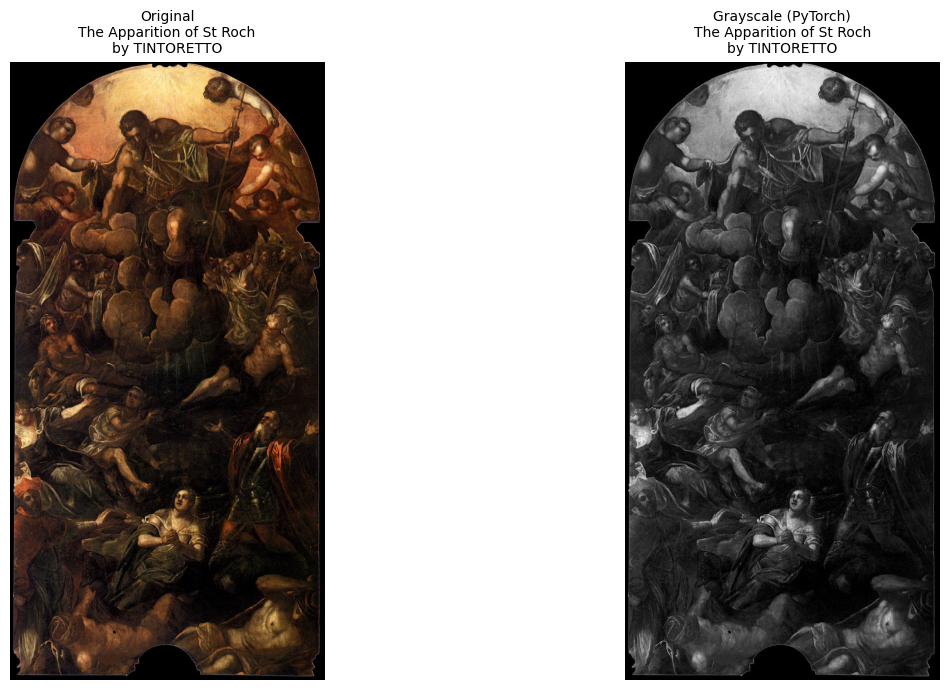


Grayscale transformation applied successfully using PyTorch!


In [15]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
import torch

# Select a random painting from the dataset
random_painting = df_train.sample(n=1, random_state=42)
image_file = random_painting['IMAGE_FILE'].values[0]
title = random_painting['TITLE'].values[0]
author = random_painting['AUTHOR'].values[0]
image_path = os.path.join("Images", image_file)

print(f"Selected painting: {title}")
print(f"Author: {author}")
print(f"File: {image_file}")

# Load the image
original_image = Image.open(image_path)

# Convert PIL Image to PyTorch tensor
to_tensor = transforms.ToTensor()
image_tensor = to_tensor(original_image)

print(f"\nOriginal image shape: {image_tensor.shape}")  # Should be [C, H, W]
print(f"Image size: {original_image.size}")

# Apply grayscale transformation using PyTorch
# Method 1: Using torchvision transforms
grayscale_transform = transforms.Grayscale(num_output_channels=1)
grayscale_tensor = grayscale_transform(original_image)
grayscale_tensor = to_tensor(grayscale_tensor)

print(f"Grayscale tensor shape: {grayscale_tensor.shape}")  # Should be [1, H, W]

# Convert tensors back to images for display
to_pil = transforms.ToPILImage()
grayscale_image = to_pil(grayscale_tensor)

# Display original and grayscale images side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

axes[0].imshow(original_image)
axes[0].set_title(f'Original\n{title}\nby {author}', fontsize=10)
axes[0].axis('off')

axes[1].imshow(grayscale_image, cmap='gray')
axes[1].set_title(f'Grayscale (PyTorch)\n{title}\nby {author}', fontsize=10)
axes[1].axis('off')

plt.tight_layout()
plt.show()

print("\nGrayscale transformation applied successfully using PyTorch!")

## Re-predict Authors on Grayscale Images

Let's take all the paintings where the author was correctly predicted and apply grayscale transformation to them, then re-predict to see how grayscale affects prediction accuracy.

In [16]:
# Function to predict author for a grayscale image
def predict_author_for_grayscale_image(image_path, authors_list, model, processor, device):
    """
    Apply grayscale transformation and predict the author of a painting using CLIP similarity
    """
    try:
        # Load the image
        image = Image.open(image_path)
        
        # Apply grayscale transformation
        grayscale_transform = transforms.Grayscale(num_output_channels=3)  # Convert to 3 channels for CLIP
        grayscale_image = grayscale_transform(image)
        
        # Preprocess inputs
        inputs = processor(text=authors_list, images=grayscale_image, return_tensors="pt", padding=True)
        
        # Move all input tensors to the same device as the model
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        # Run the model
        outputs = model(**inputs)
        image_embeddings = outputs.image_embeds
        text_embeddings = outputs.text_embeds
        
        # Compute similarity
        similarity_scores = F.cosine_similarity(image_embeddings, text_embeddings)
        
        # Get best match
        best_idx = similarity_scores.argmax().item()
        best_author = authors_list[best_idx]
        best_score = similarity_scores[best_idx].item()
        
        return best_author, best_score
    
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None, None

print("Grayscale prediction function defined successfully!")

Grayscale prediction function defined successfully!


In [17]:
# Filter for correctly predicted paintings
correct_predictions = [result for result in top100_results if result['correct']]

print(f"Total correct predictions (original color images): {len(correct_predictions)}")
print(f"We will apply grayscale to these {len(correct_predictions)} images and re-predict")

# Show sample of correctly predicted paintings
print("\nSample of correctly predicted paintings:")
for i, result in enumerate(correct_predictions[:10], 1):
    print(f"{i}. {result['title']} by {result['true_author']} (confidence: {result['confidence']:.4f})")

Total correct predictions (original color images): 2120
We will apply grayscale to these 2120 images and re-predict

Sample of correctly predicted paintings:
1. Ceiling vault (centre part) by CORTONA, Pietro da (confidence: 0.3042)
2. Christ Before King Herod (scene 14) by DUCCIO di Buoninsegna (confidence: 0.3084)
3. Samson and Delilah by CRANACH, Lucas the Elder (confidence: 0.3070)
4. What's New? (Parau Api) by GAUGUIN, Paul (confidence: 0.3492)
5. Rest on Flight to Egypt by CARAVAGGIO (confidence: 0.3110)
6. Reversible Head with Basket of Fruit by ARCIMBOLDO, Giuseppe (confidence: 0.4176)
7. The Flight into Egypt by TINTORETTO (confidence: 0.3315)
8. Trinity and Six Saints by PERUGINO, Pietro (confidence: 0.3048)
9. At the Moulin Rouge by TOULOUSE-LAUTREC, Henri de (confidence: 0.3217)
10. Flagellation by CARAVAGGIO (confidence: 0.3323)


In [18]:
# Re-predict authors on grayscale versions of correctly predicted images
grayscale_results = []

print(f"Re-predicting authors on {len(correct_predictions)} grayscale images...\n")
print("="*100)

total = len(correct_predictions)
for counter, result in enumerate(correct_predictions, 1):
    
    image_file = result['image_file']
    true_author = result['true_author']
    original_prediction = result['predicted_author']
    original_confidence = result['confidence']
    title = result['title']
    image_path = os.path.join("Images", image_file)
    
    # Show progress every 200 paintings or for first 10
    if counter <= 10 or counter % 200 == 0:
        print(f"\n[{counter}/{total}] Processing: {title} by {true_author}")
    
    # Predict author on grayscale image
    predicted_author, confidence = predict_author_for_grayscale_image(
        image_path, top_100_authors, model, processor, device
    )
    
    if predicted_author:
        is_correct = predicted_author == true_author
        symbol = "✅" if is_correct else "❌"
        
        # Only show detailed predictions for first 10 or every 200th painting
        if counter <= 10 or counter % 200 == 0:
            print(f"   Original (color): ✅ {original_prediction} (confidence: {original_confidence:.4f})")
            print(f"   Grayscale: {symbol} {predicted_author} (confidence: {confidence:.4f})")
        
        grayscale_results.append({
            'image_file': image_file,
            'title': title,
            'true_author': true_author,
            'original_prediction': original_prediction,
            'original_confidence': original_confidence,
            'grayscale_prediction': predicted_author,
            'grayscale_confidence': confidence,
            'still_correct': is_correct
        })

print(f"\n\nGrayscale re-prediction complete!")

Re-predicting authors on 2120 grayscale images...


[1/2120] Processing: Ceiling vault (centre part) by CORTONA, Pietro da
   Original (color): ✅ CORTONA, Pietro da (confidence: 0.3042)
   Grayscale: ❌ TINTORETTO (confidence: 0.2801)

[2/2120] Processing: Christ Before King Herod (scene 14) by DUCCIO di Buoninsegna
   Original (color): ✅ DUCCIO di Buoninsegna (confidence: 0.3084)
   Grayscale: ❌ GIOTTO di Bondone (confidence: 0.2877)

[3/2120] Processing: Samson and Delilah by CRANACH, Lucas the Elder
   Original (color): ✅ CRANACH, Lucas the Elder (confidence: 0.3070)
   Grayscale: ❌ TINTORETTO (confidence: 0.3091)

[4/2120] Processing: What's New? (Parau Api) by GAUGUIN, Paul
   Original (color): ✅ GAUGUIN, Paul (confidence: 0.3492)
   Grayscale: ✅ GAUGUIN, Paul (confidence: 0.3078)

[5/2120] Processing: Rest on Flight to Egypt by CARAVAGGIO
   Original (color): ✅ CARAVAGGIO (confidence: 0.3110)
   Grayscale: ❌ TINTORETTO (confidence: 0.2823)

[6/2120] Processing: Reversible Head wit

In [19]:
# Comprehensive comparison of color vs grayscale predictions
if grayscale_results:
    grayscale_results_df = pd.DataFrame(grayscale_results)
    
    print("\n" + "="*100)
    print("GRAYSCALE vs COLOR PREDICTION COMPARISON")
    print("="*100)
    
    # Calculate accuracy on grayscale
    grayscale_accuracy = grayscale_results_df['still_correct'].sum() / len(grayscale_results_df) * 100
    
    print(f"\nOriginal Color Images:")
    print(f"  Total paintings tested: {len(grayscale_results_df)}")
    print(f"  All were correctly predicted: 100% (these were the correct predictions from original test)")
    
    print(f"\nGrayscale Images:")
    print(f"  Total paintings tested: {len(grayscale_results_df)}")
    print(f"  Still correctly predicted: {grayscale_results_df['still_correct'].sum()}")
    print(f"  Accuracy: {grayscale_accuracy:.2f}%")
    
    # Calculate drop in accuracy
    accuracy_drop = 100 - grayscale_accuracy
    print(f"\nAccuracy Drop: {accuracy_drop:.2f}%")
    print(f"  ({grayscale_results_df['still_correct'].sum()}/{len(grayscale_results_df)} paintings remained correct after grayscale)")
    
    # Confidence comparison
    print(f"\nConfidence Statistics:")
    print(f"  Original (color) - Average: {grayscale_results_df['original_confidence'].mean():.4f}")
    print(f"  Grayscale - Average: {grayscale_results_df['grayscale_confidence'].mean():.4f}")
    
    confidence_diff = grayscale_results_df['grayscale_confidence'].mean() - grayscale_results_df['original_confidence'].mean()
    print(f"  Confidence change: {confidence_diff:+.4f}")
    
    # Analyze paintings that became incorrect
    became_incorrect = grayscale_results_df[~grayscale_results_df['still_correct']]
    
    if len(became_incorrect) > 0:
        print(f"\n\nPaintings that became INCORRECT after grayscale ({len(became_incorrect)} total):")
        print("-"*100)
        
        print(f"\nMost common new predictions (what model confused them with):")
        new_predictions = became_incorrect['grayscale_prediction'].value_counts().head(10)
        for author, count in new_predictions.items():
            print(f"  {author}: {count} paintings")
        
        print(f"\nAuthors most affected by grayscale (lost correct predictions):")
        affected_authors = became_incorrect['true_author'].value_counts().head(10)
        for author, count in affected_authors.items():
            total_by_author = len(grayscale_results_df[grayscale_results_df['true_author'] == author])
            print(f"  {author}: {count}/{total_by_author} became incorrect ({count/total_by_author*100:.1f}%)")
        
        print(f"\nSample of paintings that lost correct prediction:")
        display(became_incorrect[['title', 'true_author', 'original_prediction', 'grayscale_prediction', 
                                   'original_confidence', 'grayscale_confidence']].head(20))
    
    # Paintings that remained correct
    remained_correct = grayscale_results_df[grayscale_results_df['still_correct']]
    
    if len(remained_correct) > 0:
        print(f"\n\nPaintings that remained CORRECT after grayscale ({len(remained_correct)} total):")
        print("-"*100)
        
        print(f"\nAuthors most robust to grayscale:")
        robust_authors = remained_correct['true_author'].value_counts().head(10)
        for author, count in robust_authors.items():
            total_by_author = len(grayscale_results_df[grayscale_results_df['true_author'] == author])
            print(f"  {author}: {count}/{total_by_author} remained correct ({count/total_by_author*100:.1f}%)")
        
        print(f"\nSample of paintings that remained correct:")
        display(remained_correct[['title', 'true_author', 'original_confidence', 'grayscale_confidence']].head(20))
    
    print("\n\nAll Results (first 50 rows):")
    display(grayscale_results_df[['title', 'true_author', 'original_prediction', 'grayscale_prediction', 
                                   'original_confidence', 'grayscale_confidence', 'still_correct']].head(50))

else:
    print("No results to display.")


GRAYSCALE vs COLOR PREDICTION COMPARISON

Original Color Images:
  Total paintings tested: 2120
  All were correctly predicted: 100% (these were the correct predictions from original test)

Grayscale Images:
  Total paintings tested: 2120
  Still correctly predicted: 1394
  Accuracy: 65.75%

Accuracy Drop: 34.25%
  (1394/2120 paintings remained correct after grayscale)

Confidence Statistics:
  Original (color) - Average: 0.3182
  Grayscale - Average: 0.2942
  Confidence change: -0.0239


Paintings that became INCORRECT after grayscale (726 total):
----------------------------------------------------------------------------------------------------

Most common new predictions (what model confused them with):
  GOYA Y LUCIENTES, Francisco de: 81 paintings
  TINTORETTO: 56 paintings
  GIOTTO di Bondone: 35 paintings
  DÜRER, Albrecht: 32 paintings
  CLAUDE LORRAIN: 30 paintings
  BRUEGEL, Pieter the Elder: 25 paintings
  CARRACCI, Annibale: 23 paintings
  FRIEDRICH, Caspar David: 20 pai

,title,true_author,original_prediction,grayscale_prediction,original_confidence,grayscale_confidence
0,Ceiling vault (centre part),"CORTONA, Pietro da","CORTONA, Pietro da",TINTORETTO,0.304152,0.280134
1,Christ Before King Herod (scene 14),DUCCIO di Buoninsegna,DUCCIO di Buoninsegna,GIOTTO di Bondone,0.308449,0.287686
2,Samson and Delilah,"CRANACH, Lucas the Elder","CRANACH, Lucas the Elder",TINTORETTO,0.307028,0.309075
4,Rest on Flight to Egypt,CARAVAGGIO,CARAVAGGIO,TINTORETTO,0.311020,0.282265
7,Trinity and Six Saints,"PERUGINO, Pietro","PERUGINO, Pietro",GIOTTO di Bondone,0.304798,0.288681
11,Luncheon on the Grass (Le Déjeuner sur l'herbe),"MANET, Edouard","MANET, Edouard","GAUGUIN, Paul",0.305372,0.279577
15,"Dresden, the Ruins of the Pirnaische Vorstadt","BELLOTTO, Bernardo","BELLOTTO, Bernardo","RUISDAEL, Jacob Isaackszon van",0.310843,0.271544
16,The Prophet Solomon (prophet 3),DUCCIO di Buoninsegna,DUCCIO di Buoninsegna,GIOTTO di Bondone,0.325395,0.304245
18,Triptych of Haywain (central panel),"BOSCH, Hieronymus","BOSCH, Hieronymus","BRUEGEL, Pieter the Elder",0.298211,0.323337
23,The Gallery of Archduke Leopold in Brussels,"TENIERS, David the Younger","TENIERS, David the Younger","BRUEGHEL, Jan the Elder",0.285674,0.280194




Paintings that remained CORRECT after grayscale (1394 total):
----------------------------------------------------------------------------------------------------

Authors most robust to grayscale:
  REMBRANDT Harmenszoon van Rijn: 104/113 remained correct (92.0%)
  GOGH, Vincent van: 83/138 remained correct (60.1%)
  TINTORETTO: 80/96 remained correct (83.3%)
  GIOTTO di Bondone: 57/102 remained correct (55.9%)
  CANALETTO: 57/67 remained correct (85.1%)
  RUBENS, Peter Paul: 57/99 remained correct (57.6%)
  CARAVAGGIO: 56/67 remained correct (83.6%)
  CRANACH, Lucas the Elder: 53/75 remained correct (70.7%)
  GAUGUIN, Paul: 47/69 remained correct (68.1%)
  CÉZANNE, Paul: 42/64 remained correct (65.6%)

Sample of paintings that remained correct:


,title,true_author,original_confidence,grayscale_confidence
3,What's New? (Parau Api),"GAUGUIN, Paul",0.349221,0.307790
5,Reversible Head with Basket of Fruit,"ARCIMBOLDO, Giuseppe",0.417559,0.368040
6,The Flight into Egypt,TINTORETTO,0.331550,0.294128
8,At the Moulin Rouge,"TOULOUSE-LAUTREC, Henri de",0.321653,0.317757
9,Flagellation,CARAVAGGIO,0.332268,0.331451
10,Dance in the Moulin de la Galette,"RENOIR, Pierre-Auguste",0.353139,0.315233
12,Assumption of the Virgin,TINTORETTO,0.333986,0.307510
13,St John Altarpiece (closed),"MEMLING, Hans",0.316838,0.292863
14,The Watzmann,"FRIEDRICH, Caspar David",0.294701,0.262023
17,The Two Trinities,"MURILLO, Bartolomé Esteban",0.300986,0.280938




All Results (first 50 rows):


,title,true_author,original_prediction,grayscale_prediction,original_confidence,grayscale_confidence,still_correct
0,Ceiling vault (centre part),"CORTONA, Pietro da","CORTONA, Pietro da",TINTORETTO,0.304152,0.280134,False
1,Christ Before King Herod (scene 14),DUCCIO di Buoninsegna,DUCCIO di Buoninsegna,GIOTTO di Bondone,0.308449,0.287686,False
2,Samson and Delilah,"CRANACH, Lucas the Elder","CRANACH, Lucas the Elder",TINTORETTO,0.307028,0.309075,False
3,What's New? (Parau Api),"GAUGUIN, Paul","GAUGUIN, Paul","GAUGUIN, Paul",0.349221,0.307790,True
4,Rest on Flight to Egypt,CARAVAGGIO,CARAVAGGIO,TINTORETTO,0.311020,0.282265,False
5,Reversible Head with Basket of Fruit,"ARCIMBOLDO, Giuseppe","ARCIMBOLDO, Giuseppe","ARCIMBOLDO, Giuseppe",0.417559,0.368040,True
6,The Flight into Egypt,TINTORETTO,TINTORETTO,TINTORETTO,0.331550,0.294128,True
7,Trinity and Six Saints,"PERUGINO, Pietro","PERUGINO, Pietro",GIOTTO di Bondone,0.304798,0.288681,False
8,At the Moulin Rouge,"TOULOUSE-LAUTREC, Henri de","TOULOUSE-LAUTREC, Henri de","TOULOUSE-LAUTREC, Henri de",0.321653,0.317757,True
9,Flagellation,CARAVAGGIO,CARAVAGGIO,CARAVAGGIO,0.332268,0.331451,True


## Interpretation: Impact of Grayscale on Author Prediction

### What This Analysis Shows

We took all paintings where CLIP correctly identified the author using color images, then converted them to grayscale and re-predicted. This reveals:

1. **How much CLIP relies on color information** for author attribution
2. **Which artists' styles are recognizable even without color** (shape, composition, brushwork)
3. **Which artists' styles depend heavily on color** (impressionists, colorists)

### Expected Patterns

**Artists robust to grayscale** (minimal accuracy drop):
- **Sketch/line-focused artists**: Dürer, Rembrandt (strong use of line and chiaroscuro)
- **Composition-driven**: Canaletto (architectural perspective)
- **Dramatic lighting**: Caravaggio (tenebrism works in grayscale)

**Artists hurt by grayscale** (large accuracy drop):
- **Color-driven movements**: Impressionists (Monet, Renoir), Post-Impressionists (Gauguin, Van Gogh)
- **Fauvists**: Known specifically for bold, non-naturalistic color
- **Renaissance colorists**: Titian, Veronese (famous for color use)

### Why This Matters

- **For model improvement**: Reveals whether CLIP is learning visual style or just color patterns
- **For art history**: Confirms which artists had distinctive color palettes vs. distinctive compositions
- **For practical use**: Informs whether color restoration is critical for attribution tasks

Selected painting: The Apparition of St Roch
Author: TINTORETTO
File: 39373-27appari.jpg

Original image size: (800, 1575)


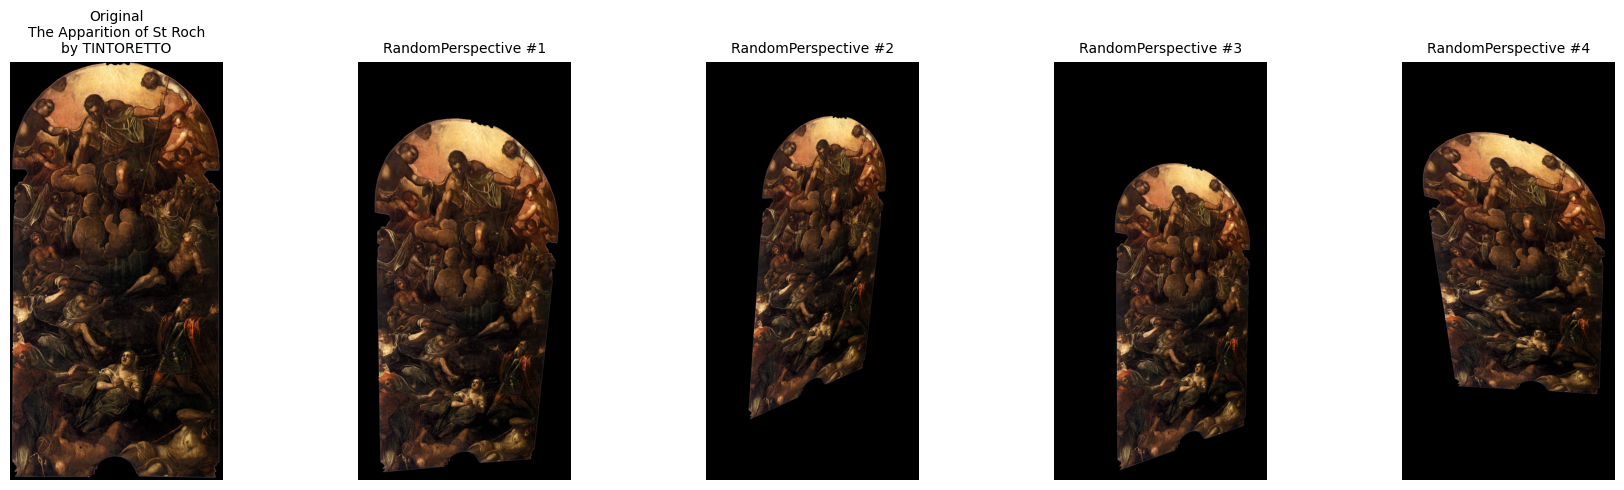


RandomPerspective transformation applied successfully!


In [20]:
import matplotlib.pyplot as plt
from PIL import Image
import os

from torchvision.transforms import v2

# Select a random painting from the dataset
random_painting = df_train.sample(n=1, random_state=42)
image_file = random_painting['IMAGE_FILE'].values[0]
title = random_painting['TITLE'].values[0]
author = random_painting['AUTHOR'].values[0]
image_path = os.path.join("Images", image_file)

print(f"Selected painting: {title}")
print(f"Author: {author}")
print(f"File: {image_file}")

# Load the image (IMPORTANT: convert to RGB)
original_image = Image.open(image_path).convert("RGB")

print(f"\nOriginal image size: {original_image.size}")

# Define RandomPerspective transform
perspective_transform = v2.RandomPerspective(
    distortion_scale=0.6,
    p=1.0
)

# Generate multiple perspective-transformed images
num_variants = 4
perspective_images = [
    perspective_transform(original_image) for _ in range(num_variants)
]

# Plot original + perspective variants
fig, axes = plt.subplots(1, num_variants + 1, figsize=(18, 5))

# Original
axes[0].imshow(original_image)
axes[0].set_title(f"Original\n{title}\nby {author}", fontsize=10)
axes[0].axis("off")

# Perspective variants
for i, img in enumerate(perspective_images, start=1):
    axes[i].imshow(img)
    axes[i].set_title(f"RandomPerspective #{i}", fontsize=10)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

print("\nRandomPerspective transformation applied successfully!")


In [21]:
def predict_author_for_perspective_image(
    image_path,
    authors_list,
    model,
    processor,
    device,
    distortion_scale=0.6
):
    """
    Apply RandomPerspective transform and predict author using CLIP
    """
    try:
        # Load image
        image = Image.open(image_path).convert("RGB")

        # Random perspective transform
        perspective_transform = v2.RandomPerspective(
            distortion_scale=distortion_scale,
            p=1.0
        )

        transformed_image = perspective_transform(image)

        # CLIP preprocessing
        inputs = processor(
            text=authors_list,
            images=transformed_image,
            return_tensors="pt",
            padding=True
        )

        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            image_embeds = outputs.image_embeds
            text_embeds = outputs.text_embeds

            similarity_scores = F.cosine_similarity(image_embeds, text_embeds)

        best_idx = similarity_scores.argmax().item()
        best_author = authors_list[best_idx]
        best_score = similarity_scores[best_idx].item()

        return best_author, best_score

    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None, None


In [22]:
perspective_results = []

print(f"Re-predicting authors with RandomPerspective on {len(correct_predictions)} images...\n")
print("=" * 100)

total = len(correct_predictions)

for counter, result in enumerate(correct_predictions, 1):

    image_file = result['image_file']
    true_author = result['true_author']
    original_prediction = result['predicted_author']
    original_confidence = result['confidence']
    title = result['title']
    image_path = os.path.join("Images", image_file)

    if counter <= 10 or counter % 200 == 0:
        print(f"\n[{counter}/{total}] Processing: {title} by {true_author}")

    predicted_author, confidence = predict_author_for_perspective_image(
        image_path,
        top_100_authors,
        model,
        processor,
        device,
        distortion_scale=0.6
    )

    if predicted_author:
        is_correct = predicted_author == true_author
        symbol = "✅" if is_correct else "❌"

        if counter <= 10 or counter % 200 == 0:
            print(f"   Original (color): ✅ {original_prediction} ({original_confidence:.4f})")
            print(f"   Perspective: {symbol} {predicted_author} ({confidence:.4f})")

        perspective_results.append({
            'image_file': image_file,
            'title': title,
            'true_author': true_author,
            'original_prediction': original_prediction,
            'original_confidence': original_confidence,
            'perspective_prediction': predicted_author,
            'perspective_confidence': confidence,
            'still_correct': is_correct
        })

print("\n\nRandomPerspective re-prediction complete!")


Re-predicting authors with RandomPerspective on 2120 images...


[1/2120] Processing: Ceiling vault (centre part) by CORTONA, Pietro da
   Original (color): ✅ CORTONA, Pietro da (0.3042)
   Perspective: ❌ MICHELANGELO Buonarroti (0.2733)

[2/2120] Processing: Christ Before King Herod (scene 14) by DUCCIO di Buoninsegna
   Original (color): ✅ DUCCIO di Buoninsegna (0.3084)
   Perspective: ✅ DUCCIO di Buoninsegna (0.3058)

[3/2120] Processing: Samson and Delilah by CRANACH, Lucas the Elder
   Original (color): ✅ CRANACH, Lucas the Elder (0.3070)
   Perspective: ❌ PINTURICCHIO (0.3203)

[4/2120] Processing: What's New? (Parau Api) by GAUGUIN, Paul
   Original (color): ✅ GAUGUIN, Paul (0.3492)
   Perspective: ✅ GAUGUIN, Paul (0.2876)

[5/2120] Processing: Rest on Flight to Egypt by CARAVAGGIO
   Original (color): ✅ CARAVAGGIO (0.3110)
   Perspective: ❌ BOTTICELLI, Sandro (0.2862)

[6/2120] Processing: Reversible Head with Basket of Fruit by ARCIMBOLDO, Giuseppe
   Original (color): ✅ ARCIM

In [23]:
perspective_df = pd.DataFrame(perspective_results)

perspective_accuracy = (
    perspective_df['still_correct'].sum() / len(perspective_df) * 100
)

print(f"\nRandomPerspective Accuracy: {perspective_accuracy:.2f}%")
print(f"Accuracy Drop: {100 - perspective_accuracy:.2f}%")

print(f"\nConfidence:")
print(f"  Original avg: {perspective_df['original_confidence'].mean():.4f}")
print(f"  Perspective avg: {perspective_df['perspective_confidence'].mean():.4f}")



RandomPerspective Accuracy: 61.37%
Accuracy Drop: 38.63%

Confidence:
  Original avg: 0.3182
  Perspective avg: 0.2984


In [24]:
# Comprehensive comparison of color vs RandomPerspective predictions
if perspective_results:
    perspective_results_df = pd.DataFrame(perspective_results)
    
    print("\n" + "="*100)
    print("RANDOM PERSPECTIVE vs COLOR PREDICTION COMPARISON")
    print("="*100)
    
    # Calculate accuracy on perspective images
    perspective_accuracy = (
        perspective_results_df['still_correct'].sum()
        / len(perspective_results_df) * 100
    )
    
    print(f"\nOriginal Color Images:")
    print(f"  Total paintings tested: {len(perspective_results_df)}")
    print(f"  All were correctly predicted: 100% (these were the correct predictions from original test)")
    
    print(f"\nRandomPerspective Images:")
    print(f"  Total paintings tested: {len(perspective_results_df)}")
    print(f"  Still correctly predicted: {perspective_results_df['still_correct'].sum()}")
    print(f"  Accuracy: {perspective_accuracy:.2f}%")
    
    # Calculate drop in accuracy
    accuracy_drop = 100 - perspective_accuracy
    print(f"\nAccuracy Drop: {accuracy_drop:.2f}%")
    print(
        f"  ({perspective_results_df['still_correct'].sum()}"
        f"/{len(perspective_results_df)} paintings remained correct after RandomPerspective)"
    )
    
    # Confidence comparison
    print(f"\nConfidence Statistics:")
    print(f"  Original (color) - Average: {perspective_results_df['original_confidence'].mean():.4f}")
    print(f"  RandomPerspective - Average: {perspective_results_df['perspective_confidence'].mean():.4f}")
    
    confidence_diff = (
        perspective_results_df['perspective_confidence'].mean()
        - perspective_results_df['original_confidence'].mean()
    )
    print(f"  Confidence change: {confidence_diff:+.4f}")
    
    # Analyze paintings that became incorrect
    became_incorrect = perspective_results_df[~perspective_results_df['still_correct']]
    
    if len(became_incorrect) > 0:
        print(
            f"\n\nPaintings that became INCORRECT after RandomPerspective "
            f"({len(became_incorrect)} total):"
        )
        print("-"*100)
        
        print(f"\nMost common new predictions (what model confused them with):")
        new_predictions = (
            became_incorrect['perspective_prediction']
            .value_counts()
            .head(10)
        )
        for author, count in new_predictions.items():
            print(f"  {author}: {count} paintings")
        
        print(f"\nAuthors most affected by RandomPerspective (lost correct predictions):")
        affected_authors = became_incorrect['true_author'].value_counts().head(10)
        for author, count in affected_authors.items():
            total_by_author = len(
                perspective_results_df[
                    perspective_results_df['true_author'] == author
                ]
            )
            print(
                f"  {author}: {count}/{total_by_author} became incorrect "
                f"({count/total_by_author*100:.1f}%)"
            )
        
        print(f"\nSample of paintings that lost correct prediction:")
        display(
            became_incorrect[
                [
                    'title',
                    'true_author',
                    'original_prediction',
                    'perspective_prediction',
                    'original_confidence',
                    'perspective_confidence'
                ]
            ].head(20)
        )
    
    # Paintings that remained correct
    remained_correct = perspective_results_df[perspective_results_df['still_correct']]
    
    if len(remained_correct) > 0:
        print(
            f"\n\nPaintings that remained CORRECT after RandomPerspective "
            f"({len(remained_correct)} total):"
        )
        print("-"*100)
        
        print(f"\nAuthors most robust to RandomPerspective:")
        robust_authors = remained_correct['true_author'].value_counts().head(10)
        for author, count in robust_authors.items():
            total_by_author = len(
                perspective_results_df[
                    perspective_results_df['true_author'] == author
                ]
            )
            print(
                f"  {author}: {count}/{total_by_author} remained correct "
                f"({count/total_by_author*100:.1f}%)"
            )
        
        print(f"\nSample of paintings that remained correct:")
        display(
            remained_correct[
                [
                    'title',
                    'true_author',
                    'original_confidence',
                    'perspective_confidence'
                ]
            ].head(20)
        )
    
    print("\n\nAll Results (first 50 rows):")
    display(
        perspective_results_df[
            [
                'title',
                'true_author',
                'original_prediction',
                'perspective_prediction',
                'original_confidence',
                'perspective_confidence',
                'still_correct'
            ]
        ].head(50)
    )

else:
    print("No results to display.")



RANDOM PERSPECTIVE vs COLOR PREDICTION COMPARISON

Original Color Images:
  Total paintings tested: 2120
  All were correctly predicted: 100% (these were the correct predictions from original test)

RandomPerspective Images:
  Total paintings tested: 2120
  Still correctly predicted: 1301
  Accuracy: 61.37%

Accuracy Drop: 38.63%
  (1301/2120 paintings remained correct after RandomPerspective)

Confidence Statistics:
  Original (color) - Average: 0.3182
  RandomPerspective - Average: 0.2984
  Confidence change: -0.0198


Paintings that became INCORRECT after RandomPerspective (819 total):
----------------------------------------------------------------------------------------------------

Most common new predictions (what model confused them with):
  PINTURICCHIO: 134 paintings
  PERUGINO, Pietro: 53 paintings
  TINTORETTO: 42 paintings
  GIOTTO di Bondone: 29 paintings
  FRAGONARD, Jean-Honoré: 28 paintings
  VERMEER, Johannes: 27 paintings
  SIMONE MARTINI: 25 paintings
  GOYA Y LUC

,title,true_author,original_prediction,perspective_prediction,original_confidence,perspective_confidence
0,Ceiling vault (centre part),"CORTONA, Pietro da","CORTONA, Pietro da",MICHELANGELO Buonarroti,0.304152,0.273345
2,Samson and Delilah,"CRANACH, Lucas the Elder","CRANACH, Lucas the Elder",PINTURICCHIO,0.307028,0.320342
4,Rest on Flight to Egypt,CARAVAGGIO,CARAVAGGIO,"BOTTICELLI, Sandro",0.311020,0.286178
11,Luncheon on the Grass (Le Déjeuner sur l'herbe),"MANET, Edouard","MANET, Edouard","GOYA Y LUCIENTES, Francisco de",0.305372,0.287648
14,The Watzmann,"FRIEDRICH, Caspar David","FRIEDRICH, Caspar David","RUISDAEL, Jacob Isaackszon van",0.294701,0.267605
17,The Two Trinities,"MURILLO, Bartolomé Esteban","MURILLO, Bartolomé Esteban","TIEPOLO, Giovanni Domenico",0.300986,0.283158
18,Triptych of Haywain (central panel),"BOSCH, Hieronymus","BOSCH, Hieronymus",PINTURICCHIO,0.298211,0.302227
20,Love as Folly,"FRAGONARD, Jean-Honoré","FRAGONARD, Jean-Honoré","GOYA Y LUCIENTES, Francisco de",0.353379,0.296671
23,The Gallery of Archduke Leopold in Brussels,"TENIERS, David the Younger","TENIERS, David the Younger",PINTURICCHIO,0.285674,0.296723
24,Woman with a Parasol in a Garden,"RENOIR, Pierre-Auguste","RENOIR, Pierre-Auguste","MONET, Claude",0.326926,0.304468




Paintings that remained CORRECT after RandomPerspective (1301 total):
----------------------------------------------------------------------------------------------------

Authors most robust to RandomPerspective:
  GOGH, Vincent van: 103/138 remained correct (74.6%)
  TINTORETTO: 76/96 remained correct (79.2%)
  REMBRANDT Harmenszoon van Rijn: 67/113 remained correct (59.3%)
  CANALETTO: 65/67 remained correct (97.0%)
  CARAVAGGIO: 63/67 remained correct (94.0%)
  GIOTTO di Bondone: 54/102 remained correct (52.9%)
  GAUGUIN, Paul: 51/69 remained correct (73.9%)
  RUBENS, Peter Paul: 48/99 remained correct (48.5%)
  TOULOUSE-LAUTREC, Henri de: 47/58 remained correct (81.0%)
  CÉZANNE, Paul: 41/64 remained correct (64.1%)

Sample of paintings that remained correct:


,title,true_author,original_confidence,perspective_confidence
1,Christ Before King Herod (scene 14),DUCCIO di Buoninsegna,0.308449,0.305833
3,What's New? (Parau Api),"GAUGUIN, Paul",0.349221,0.287585
5,Reversible Head with Basket of Fruit,"ARCIMBOLDO, Giuseppe",0.417559,0.395742
6,The Flight into Egypt,TINTORETTO,0.331550,0.283110
7,Trinity and Six Saints,"PERUGINO, Pietro",0.304798,0.318031
8,At the Moulin Rouge,"TOULOUSE-LAUTREC, Henri de",0.321653,0.275345
9,Flagellation,CARAVAGGIO,0.332268,0.312677
10,Dance in the Moulin de la Galette,"RENOIR, Pierre-Auguste",0.353139,0.287889
12,Assumption of the Virgin,TINTORETTO,0.333986,0.311901
13,St John Altarpiece (closed),"MEMLING, Hans",0.316838,0.312240




All Results (first 50 rows):


,title,true_author,original_prediction,perspective_prediction,original_confidence,perspective_confidence,still_correct
0,Ceiling vault (centre part),"CORTONA, Pietro da","CORTONA, Pietro da",MICHELANGELO Buonarroti,0.304152,0.273345,False
1,Christ Before King Herod (scene 14),DUCCIO di Buoninsegna,DUCCIO di Buoninsegna,DUCCIO di Buoninsegna,0.308449,0.305833,True
2,Samson and Delilah,"CRANACH, Lucas the Elder","CRANACH, Lucas the Elder",PINTURICCHIO,0.307028,0.320342,False
3,What's New? (Parau Api),"GAUGUIN, Paul","GAUGUIN, Paul","GAUGUIN, Paul",0.349221,0.287585,True
4,Rest on Flight to Egypt,CARAVAGGIO,CARAVAGGIO,"BOTTICELLI, Sandro",0.311020,0.286178,False
5,Reversible Head with Basket of Fruit,"ARCIMBOLDO, Giuseppe","ARCIMBOLDO, Giuseppe","ARCIMBOLDO, Giuseppe",0.417559,0.395742,True
6,The Flight into Egypt,TINTORETTO,TINTORETTO,TINTORETTO,0.331550,0.283110,True
7,Trinity and Six Saints,"PERUGINO, Pietro","PERUGINO, Pietro","PERUGINO, Pietro",0.304798,0.318031,True
8,At the Moulin Rouge,"TOULOUSE-LAUTREC, Henri de","TOULOUSE-LAUTREC, Henri de","TOULOUSE-LAUTREC, Henri de",0.321653,0.275345,True
9,Flagellation,CARAVAGGIO,CARAVAGGIO,CARAVAGGIO,0.332268,0.312677,True


In [25]:
grayscale_results_df.to_csv("grayscale_results_df.csv", index=False)
perspective_results_df.to_csv("perspective_results_df.csv", index=False)